In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, TensorDataset
import gymnasium as gym

from astropy.io import fits
from datetime import datetime, timezone
import json
import fitsio
import pandas as pd
import time
import pickle
import re



%reload_ext autoreload
%autoreload 2

In [2]:
import survey_ops
from survey_ops.utils import units, geometry, interpolate
from survey_ops.src.offline_dataset import OfflineDECamDataset
from survey_ops.src.agents import Agent
from survey_ops.src.algorithms import DDQN, BehaviorCloning
from survey_ops.utils.pytorch_utils import seed_everything


In [3]:
SEED = 10
seed_everything(SEED)
torch.set_default_dtype(torch.float32)
device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "cpu"   
)

# Load and cut data from fits file, save as .json

In [4]:
data_json_fn = '../data/decam-exposures-20251211.json'
data_fits_fn = '../data/decam-exposures-20251211.fits'
data_json_full_fn = '../data/decam-exposures-20251211-full.json'


In [5]:
try:
    # --- Load json df ---- #
    df = pd.read_json(data_json_fn)
    print('Loaded data from json')
except:
    # --- Load fits ---- #
    print("No .json file found. Instead loading and processing .fits file.")
    d = fitsio.read(data_fits_fn)
    sel = (d['propid'] == '2012B-0001') & (d['exptime'] > 40) & (d['exptime'] < 100) & (~np.isnan(d['teff']))
    selected_d = d[sel]
    column_names = selected_d.dtype.names
    df = pd.DataFrame(selected_d, columns=column_names)
    df['datetime'] = pd.to_datetime(df['datetime'], utc=True)
    df['night'] = (df['datetime'] - pd.Timedelta(hours=12)).dt.normalize()
    df.to_json(data_json_fn, indent=2)
    df = pd.read_json(data_json_fn)
    

Loaded data from json


# Instantiate the offline dataset choosing binning method (healpix vs uniform_grid)

In [6]:
with open('../experiment_results/bc-radec-incl-grid-features/offline_dataset_config.pkl', 'rb') as f:
    data_config = pickle.load(f)
with open('../experiment_results/bc-radec-incl-grid-features/model_hyperparams.pkl', 'rb') as f:
    model_hyperparams = pickle.load(f)

In [7]:
sample_dataset = OfflineDECamDataset(
    df=df,
    specific_years=[2018], 
    **data_config
    )

Calculating sun and moon ra/dec and az/el: 100%|█| 11707/11707 [00:09<00:00, 125
Calculating zenith states: 100%|███████████████| 98/98 [00:00<00:00, 770.84it/s]
Calculating bin features for all healpix bins and timestamps: 100%|█| 11805/1180
Normalizing bin features: 100%|████████| 15360/15360 [00:01<00:00, 13054.57it/s]


In [8]:
train_dataset = OfflineDECamDataset(
    df=df,
    specific_years=[2018], 
    specific_months=[1], 
    **data_config
    )

Calculating sun and moon ra/dec and az/el: 100%|█| 1785/1785 [00:01<00:00, 1290.
Calculating zenith states: 100%|██████████████| 23/23 [00:00<00:00, 1091.38it/s]
Calculating bin features for all healpix bins and timestamps: 100%|█| 1808/1808 
Normalizing bin features: 100%|████████| 15360/15360 [00:00<00:00, 70669.19it/s]


In [20]:
trainloader, valloader = sample_dataset.get_dataloader(
    batch_size=512,
    num_workers=4,
    pin_memory=True if device.type == 'cuda' else False,
    random_seed=SEED,
    return_train_and_val=True
)


In [92]:
train_actions = trainloader.dataset.dataset.actions[trainloader.dataset.indices].detach().numpy()
val_actions = valloader.dataset.dataset.actions[valloader.dataset.indices].detach().numpy()
train_states = trainloader.dataset.dataset.states[trainloader.dataset.indices].detach().numpy()
val_states = valloader.dataset.dataset.states[valloader.dataset.indices].detach().numpy()


In [94]:
train_states.shape

(10536, 21526)

In [22]:
from survey_ops.utils.script_utils import setup_algorithm
trained_model_dir = '../experiment_results/bc-radec-incl-grid-features/'
algorithm = setup_algorithm(**model_hyperparams, device=device)
agent = Agent(
    algorithm=algorithm,
    train_outdir=trained_model_dir,
)
agent.load(trained_model_dir + 'best_weights.pt')

# Baseline
If I always picked the most common action in the train dataset, how often would I guess the correct in bin?

In [23]:
el, counts = np.unique(train_actions, return_counts=True)

In [24]:
most_common_bin = el[np.argmax(counts)]
baseline = (most_common_bin == val_actions).mean()

In [25]:
baseline

np.float64(0.005977796754910333)

(array([0.00025371, 0.0002699 , 0.00019433, 0.00029689, 0.00079891,
        0.00064777, 0.00094466, 0.00073953, 0.00120376, 0.00097165]),
 array([1376. , 1534.2, 1692.4, 1850.6, 2008.8, 2167. , 2325.2, 2483.4,
        2641.6, 2799.8, 2958. ]),
 <BarContainer object of 10 artists>)

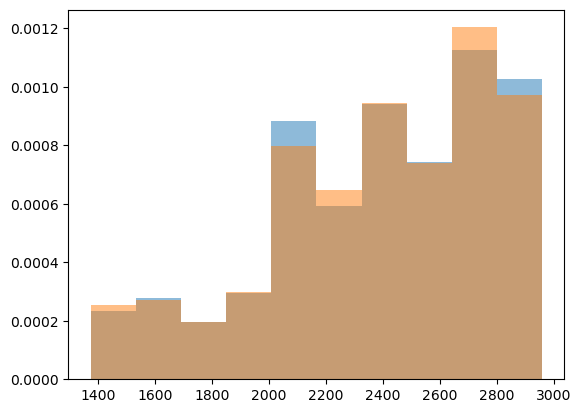

In [26]:
plt.hist(train_actions, density=True, alpha=.5)
plt.hist(val_actions, density=True, alpha=.5)

# Train random forest

In [27]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, max_depth=15)
rf.fit(train_states, train_actions)
rf_acc = rf.score(val_states, val_actions)

In [28]:
rf_acc

0.2707087959009394

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

X_A = np.concatenate([S_t, A_t], axis=1)
X_B = np.concatenate([S_tm1, S_t, A_t], axis=1)
Y = S_tp1

rf_A = RandomForestRegressor(n_estimators=200)
rf_B = RandomForestRegressor(n_estimators=200)

rf_A.fit(X_A_train, Y_train)
rf_B.fit(X_B_train, Y_train)

pred_A = rf_A.predict(X_A_val)
pred_B = rf_B.predict(X_B_val)

err_A = mean_squared_error(Y_val, pred_A)
err_B = mean_squared_error(Y_val, pred_B)

print("Markov error:", err_A)
print("History error:", err_B)
print("Relative improvement:", (err_A - err_B) / err_A)


# Distribution shift

Text(0.5, 1.0, 'PCA latent space')

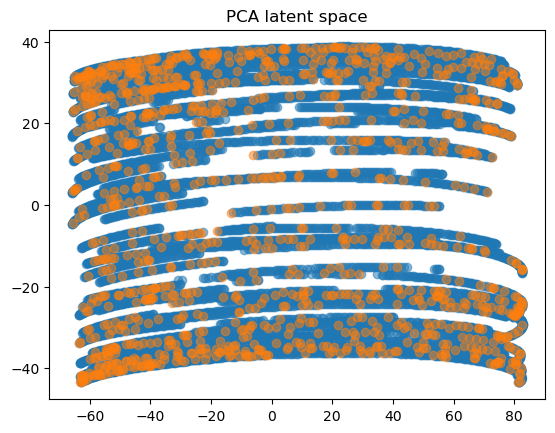

In [29]:
# Are train/val from different time periods?
# Visualize with PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
train_2d = pca.fit_transform(train_states)
val_2d = pca.transform(val_states)
plt.scatter(train_2d[:,0], train_2d[:,1], label='train', alpha=0.5)
plt.scatter(val_2d[:,0], val_2d[:,1], label='val', alpha=0.5)
plt.title('PCA latent space')

In [70]:
map_night2idx = {night_str: i for i, night_str in enumerate(np.unique(sample_dataset._df['night']))}

In [81]:
sample_dataset._df.keys()

Index(['expnum', 'ra', 'dec', 'exptime', 'filter', 'propid', 'program',
       'object', 'teff', 'fwhm', 'datetime', 'az', 'zd', 'ha', 'airmass',
       'qc_fwhm', 'qc_cloud', 'qc_sky', 'qc_teff', 'night', 'timestamp',
       'sun_ra', 'sun_dec', 'sun_az', 'sun_el', 'moon_ra', 'moon_dec',
       'moon_az', 'moon_el', 'time_fraction_since_start', 'ra_cos', 'ra_sin',
       'az_cos', 'az_sin', 'ha_cos', 'ha_sin', 'sun_ra_cos', 'sun_ra_sin',
       'sun_az_cos', 'sun_az_sin', 'moon_ra_cos', 'moon_ra_sin', 'moon_az_cos',
       'moon_az_sin', 'el', 'bin', 'field_id'],
      dtype='object')

In [84]:
timestamps = sample_dataset._df['timestamp'][sample_dataset._df['object'] != 'zenith'].values
c_nights = [map_night2idx[night_str] for night_str in sample_dataset._df['night'][sample_dataset._df['object'] != 'zenith'].values]
c_time_fractions = sample_dataset.states[:, 21]
c_sun_el = sample_dataset._df['sun_el'][sample_dataset._df['object'] != 'zenith'].values
c_moon_el = sample_dataset._df['moon_el'][sample_dataset._df['object'] != 'zenith'].values


NameError: name 'current_bins' is not defined

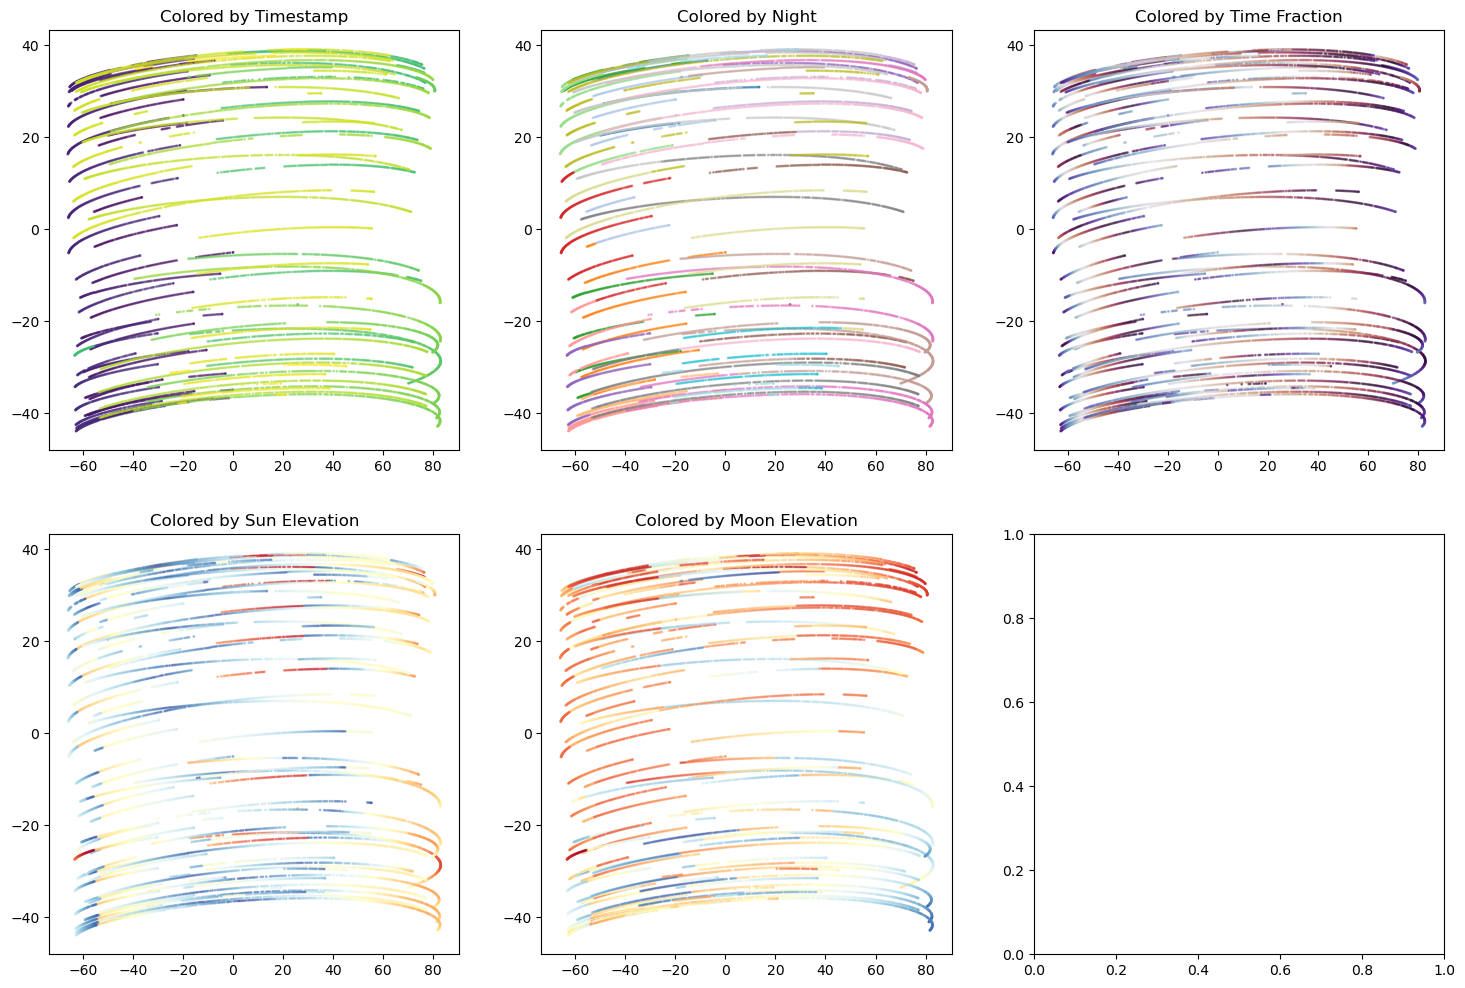

In [85]:
# Understanding what causes the stripes in PCA
pca = PCA(n_components=2)
all_states = sample_dataset.states
all_states_2d = pca.fit_transform(all_states)

# Color by different variables to see what creates the pattern
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Plot 1: Color by time
axes[0, 0].scatter(all_states_2d[:, 0], all_states_2d[:, 1], 
                   c=timestamps, cmap='viridis', s=1, alpha=0.5)
axes[0, 0].set_title('Colored by Timestamp')

# Plot 2: Color by night index
axes[0, 1].scatter(all_states_2d[:, 0], all_states_2d[:, 1], 
                   c=c_nights, cmap='tab20', s=1, alpha=0.5)
axes[0, 1].set_title('Colored by Night')

# Plot 3: Color by time fraction
axes[0, 2].scatter(all_states_2d[:, 0], all_states_2d[:, 1], 
                   c=c_time_fractions, cmap='twilight', s=1, alpha=0.5)
axes[0, 2].set_title('Colored by Time Fraction')

# Plot 4: Color by sun elevation
axes[1, 0].scatter(all_states_2d[:, 0], all_states_2d[:, 1], 
                   c=c_sun_el, cmap='RdYlBu', s=1, alpha=0.5)
axes[1, 0].set_title('Colored by Sun Elevation')

# Plot 5: Color by moon elevation
axes[1, 1].scatter(all_states_2d[:, 0], all_states_2d[:, 1], 
                   c=c_moon_el, cmap='RdYlBu', s=1, alpha=0.5)
axes[1, 1].set_title('Colored by Moon Elevation')

# Plot 6: Color by current bin
axes[1, 2].scatter(all_states_2d[:, 0], all_states_2d[:, 1], 
                   c=current_bins, cmap='tab20', s=1, alpha=0.5)
axes[1, 2].set_title('Colored by Current Bin')

plt.tight_layout()
plt.savefig('pca_investigation.png', dpi=150)

# Confusion matrix

In [30]:
from sklearn.metrics import confusion_matrix
with torch.no_grad():
    q_vals = agent.algorithm.policy_net(torch.tensor(val_states).to(device))
    predictions = torch.argmax(q_vals, dim=1).to('cpu').detach().numpy()
cm = confusion_matrix(val_actions, predictions)

In [88]:
predictions

array([2222, 1383, 2815, ..., 2149, 2897, 2280], shape=(1171,))

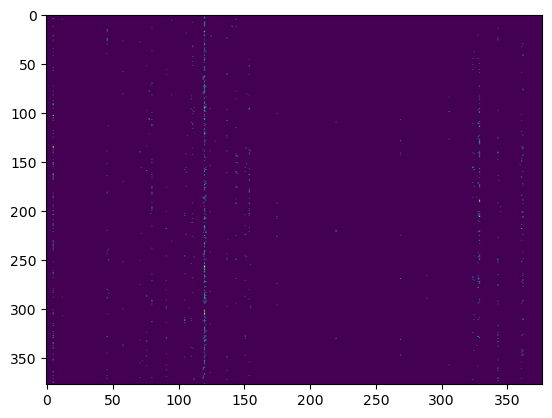

In [86]:
plt.imshow(cm, aspect='auto')

I ran your diagnostics. I got that:

1. Baseline is 2.2%
2. RF accuracy is 35%
3. plot

In [88]:
df.columns

Index(['expnum', 'ra', 'dec', 'exptime', 'filter', 'propid', 'program',
       'object', 'teff', 'fwhm', 'datetime', 'az', 'zd', 'ha', 'airmass',
       'qc_fwhm', 'qc_cloud', 'qc_sky', 'qc_teff', 'night'],
      dtype='object')

In [132]:
train_dataset._df.groupby('night').tail(1)['sun_el'] / units.deg

55     -37.068035
154    -37.246365
209    -37.463791
238    -37.453022
322    -37.760826
402    -37.887539
464    -38.013680
530    -38.169643
574    -38.544277
639    -38.682873
729    -38.895561
812    -39.104549
896    -39.295525
988    -39.512638
1050   -39.687263
1137   -39.913101
1232   -40.170193
1324   -40.376804
1418   -40.638161
1498   -40.817287
1588   -41.112167
1667   -41.389069
1784   -41.643227
Name: sun_el, dtype: float32

In [138]:
sample_dataset._df.groupby('night').tail(1)['sun_el'] / units.deg, sample_dataset._df.groupby('night').tail(1)['datetime']

(55      -37.068035
 154     -37.246365
 209     -37.463791
 238     -37.453022
 322     -37.760826
            ...    
 11540   -36.373158
 11600   -36.529865
 11637   -36.611866
 11667   -36.644424
 11706   -36.736008
 Name: sun_el, Length: 98, dtype: float32,
 55      2018-01-04 05:00:21
 154     2018-01-05 04:49:04
 209     2018-01-07 04:43:42
 238     2018-01-08 04:33:25
 322     2018-01-09 04:50:47
                 ...        
 11540   2018-12-19 04:31:40
 11600   2018-12-28 04:37:41
 11637   2018-12-29 04:42:25
 11667   2018-12-30 04:38:20
 11706   2018-12-31 04:41:38
 Name: datetime, Length: 98, dtype: datetime64[ns])

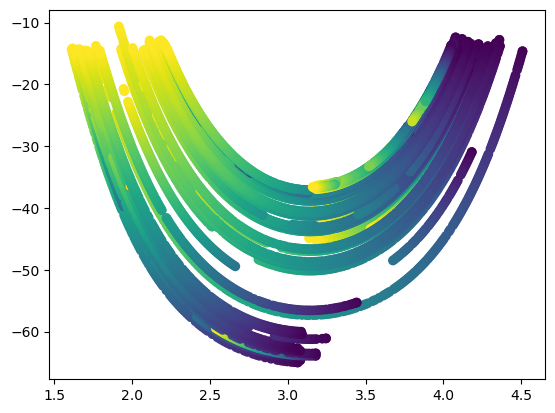

In [140]:
for night, subdf in sample_dataset._df.groupby('night'):
    plt.scatter(subdf['sun_az'].values, subdf['sun_el'].values/units.deg, c=np.arange(len(subdf)))

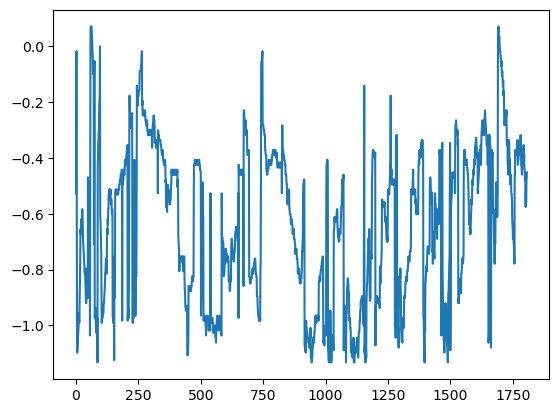

In [128]:
plt.plot(train_dataset._df['dec'].values)

In [95]:
import ephem

In [96]:
from survey_ops.utils.ephemerides import blanco_observer

In [105]:
obs = blanco_observer(time=train_dataset._df['timestamp'].values[-1])

In [14]:
trainloader.dataset.dataset.states.shape

torch.Size([16589, 22])

In [13]:
valloader.dataset.dataset.states.shape

torch.Size([16589, 22])

In [11]:
import seaborn as sns

In [12]:
train_dataset._df.keys()

Index(['expnum', 'ra', 'dec', 'exptime', 'filter', 'propid', 'program',
       'object', 'teff', 'fwhm', 'datetime', 'az', 'zd', 'ha', 'airmass',
       'qc_fwhm', 'qc_cloud', 'qc_sky', 'qc_teff', 'night', 'timestamp',
       'sun_ra', 'sun_dec', 'sun_az', 'sun_el', 'moon_ra', 'moon_dec',
       'moon_az', 'moon_el', 'time_fraction_since_start', 'ra_cos', 'ra_sin',
       'az_cos', 'az_sin', 'ha_cos', 'ha_sin', 'sun_ra_cos', 'sun_ra_sin',
       'sun_az_cos', 'sun_az_sin', 'moon_ra_cos', 'moon_ra_sin', 'moon_az_cos',
       'moon_az_sin', 'el', 'bin', 'field_id'],
      dtype='object')

In [13]:
train_dataset.base_feature_names

['ra',
 'dec',
 'az',
 'el',
 'airmass',
 'ha',
 'sun_ra',
 'sun_dec',
 'sun_az',
 'sun_el',
 'moon_ra',
 'moon_dec',
 'moon_az',
 'moon_el',
 'time_fraction_since_start']

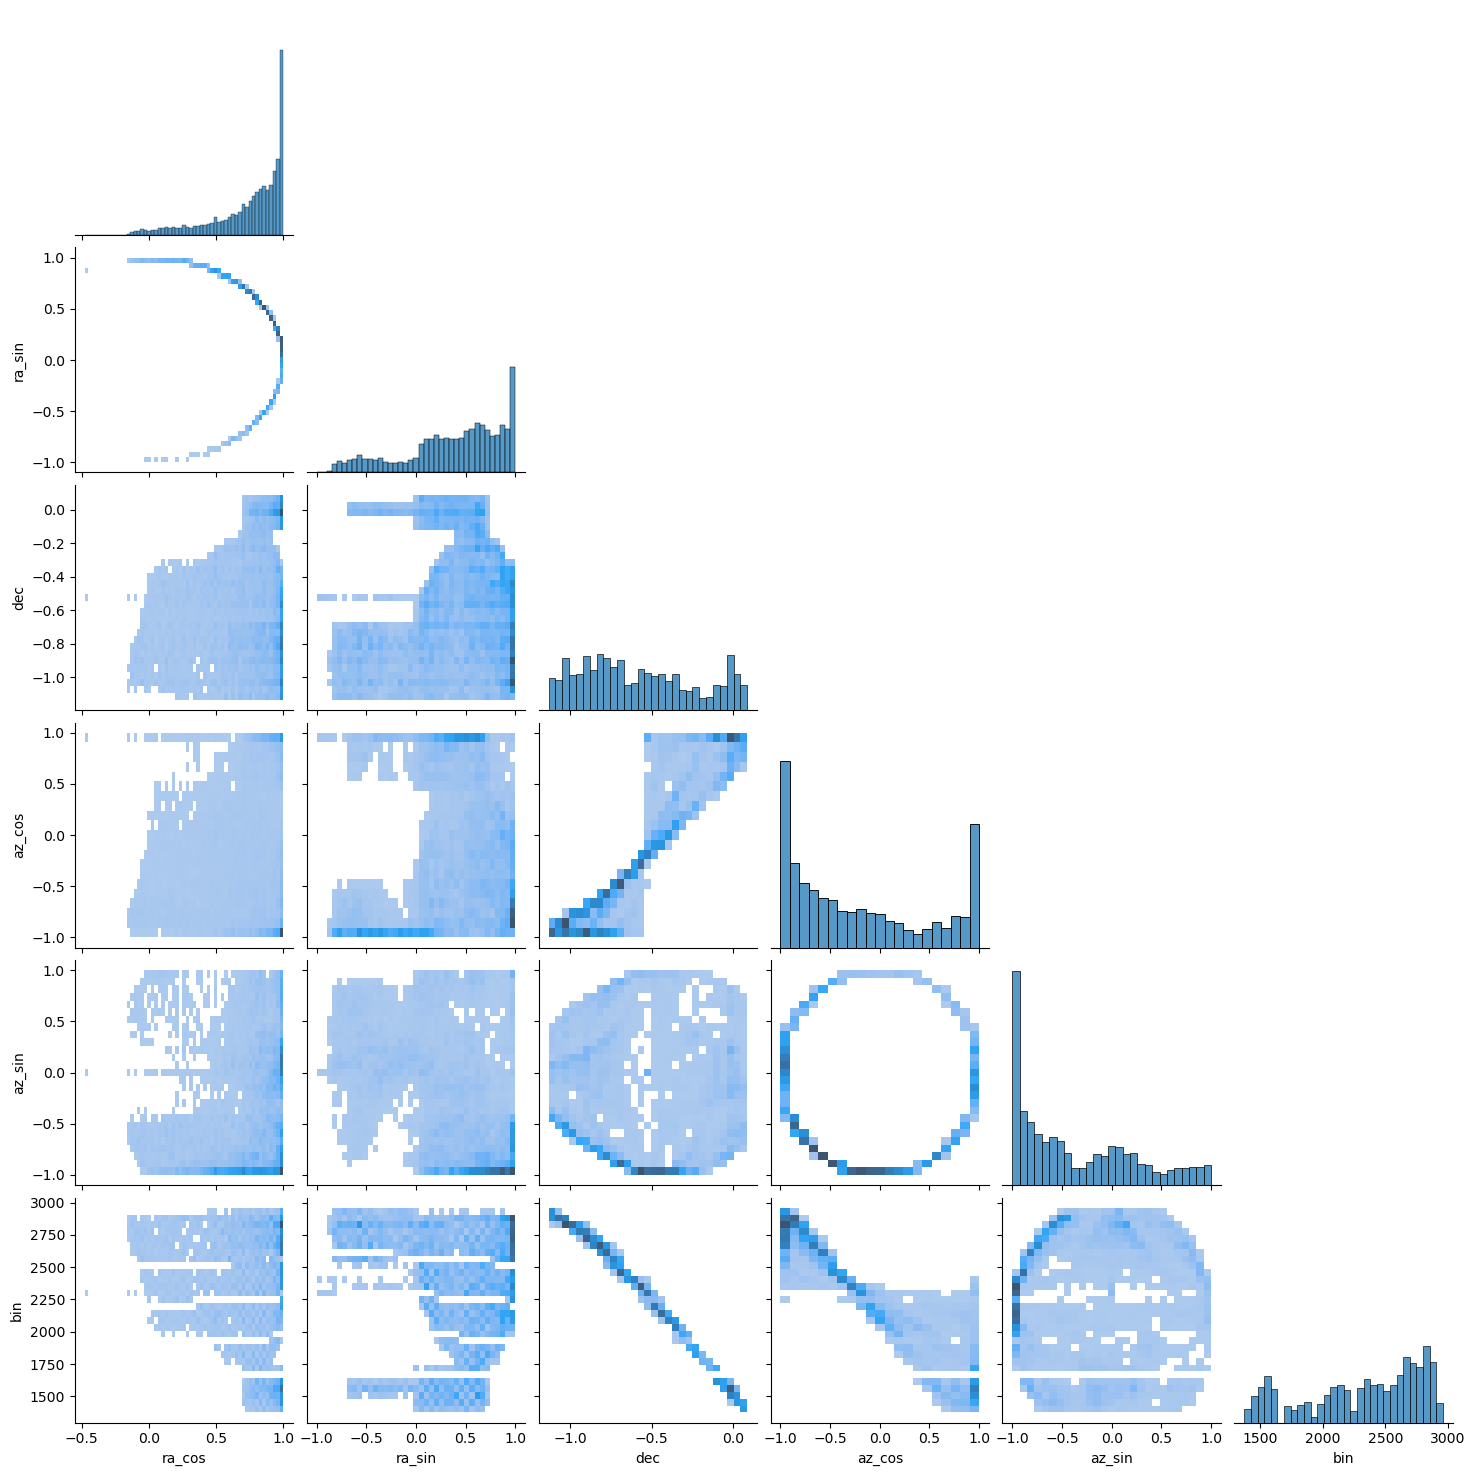

In [29]:
corner_plot = sns.pairplot(train_dataset._df,
             vars=train_dataset.state_feature_names[:5] + ['bin'],
             kind='hist',
             corner=True
            )

In [33]:
with open('../experiment_results/bc-radec/train_metrics.pkl', 'rb') as f:
    train_metrics = pickle.load(f)
with open('../experiment_results/bc-radec/val_metrics.pkl', 'rb') as f:
    val_metrics = pickle.load(f)

In [34]:
train_metrics.keys()

dict_keys(['train_loss', 'train_qvals', 'lr'])

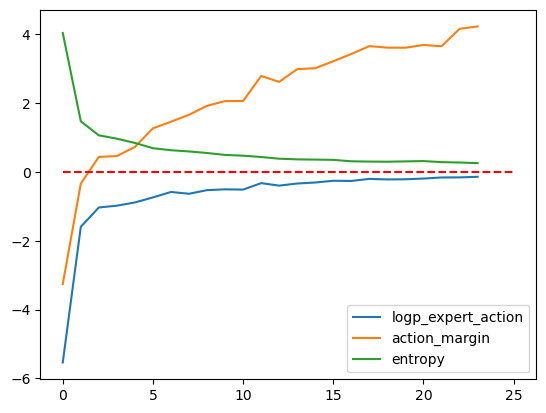

In [45]:
for key in val_metrics.keys():
    if key != 'accuracy' and 'loss' not in key:
        plt.plot(val_metrics[key], label=key)
plt.hlines(0, xmin=0, xmax=25, linestyle='--', color='red')
plt.legend()

In [46]:
val_metrics.keys()

dict_keys(['val_loss', 'logp_expert_action', 'action_margin', 'entropy', 'accuracy'])

In [43]:
# for night, subdf in train_dataset._df.groupby('night'):
#     diff_in_exptime = np.diff(subdf['exptime'].values)
#     plt.plot(diff_in_exptime, marker='o')
#     plt.title(night)
#     print(f"mean {np.mean(diff_in_exptime)}, std {np.std(diff_in_exptime)}, max {np.max(diff_in_exptime)}, min {np.min(diff_in_exptime)})
#     break

In [44]:
# train_dataset._df.loc[~train_dataset._df['object'].isin(['DES wide hex', 'DES survey hex'])]['object'].unique()

In [45]:
# masks = ~train_dataset._df['object'].str.contains('DES wide hex') 
# masks &= ~train_dataset._df['object'].str.contains('DES survey hex') 
# masks &= ~train_dataset._df['object'].str.contains('zenith') 
# # masks &= ~train_dataset._df['object'].str.contains('DES wide hex') 
# potential_lo = train_dataset._df['object'][masks].unique()

In [167]:
night

Timestamp('2019-01-09 00:00:00')

In [168]:
train_dataset._df['night'] = pd.Timestamp('2019-01-09 00:00:00')

In [55]:
a.dayofyear

243

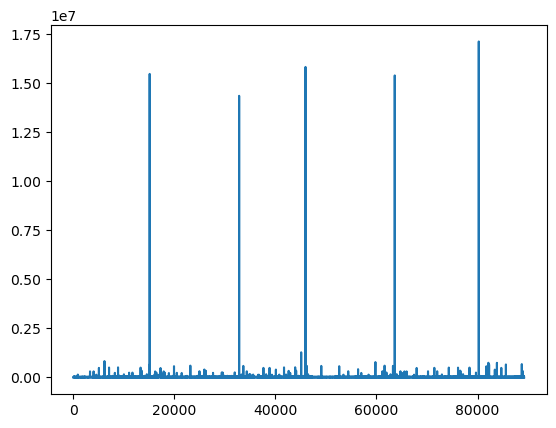

In [24]:
time_between_obs = np.diff(train_dataset._df['timestamp'])
plt.plot(time_between_obs)

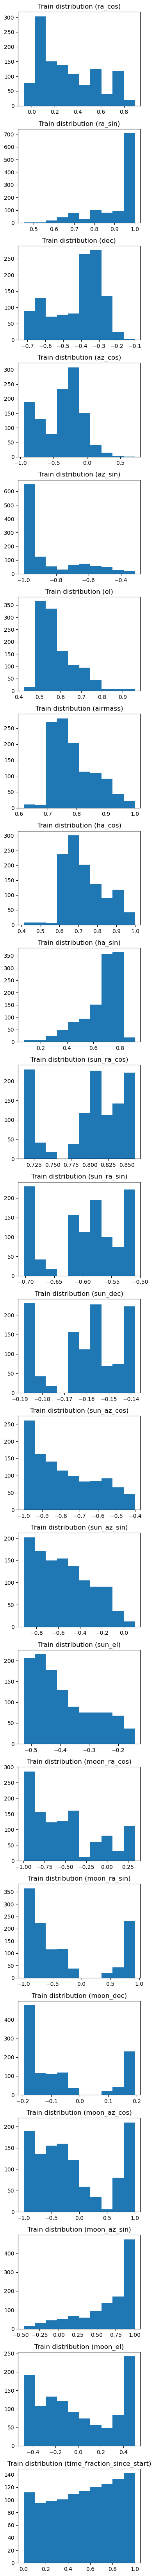

In [7]:

fig, axs = plt.subplots(len(train_dataset.state_feature_names), figsize=(4, len(train_dataset.state_feature_names)*3))
for i, feat_row in enumerate(train_dataset.next_states.T):
    axs[i].hist(feat_row)
    axs[i].set_title(f"Train distribution ({train_dataset.state_feature_names[i]})")
fig.tight_layout()

# Visualize dataset in az, el and ra, dec

In [10]:
obj_names, counts = np.unique(train_dataset._df.object, return_counts=True)

Text(0, 0.5, 'Number of fields')

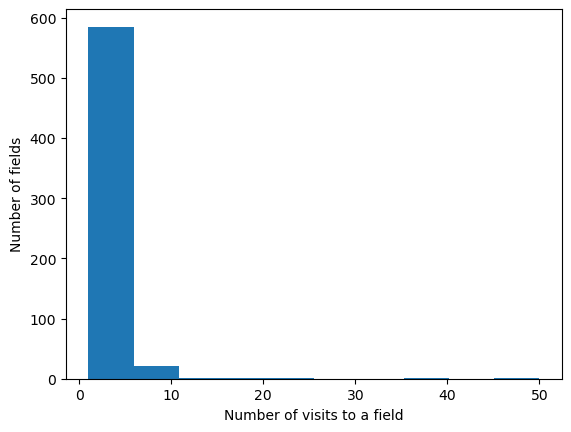

In [11]:
plt.hist(counts)
plt.xlabel('Number of visits to a field')
plt.ylabel('Number of fields')

Text(0.5, 0, 'Number of observations in a night')

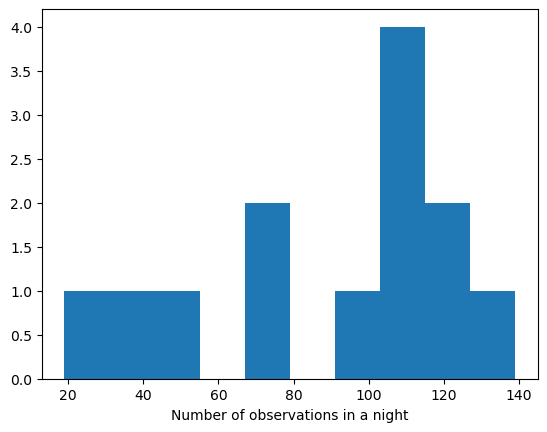

In [13]:
plt.hist(train_dataset.n_obs_per_night)
plt.xlabel('Number of observations in a night')

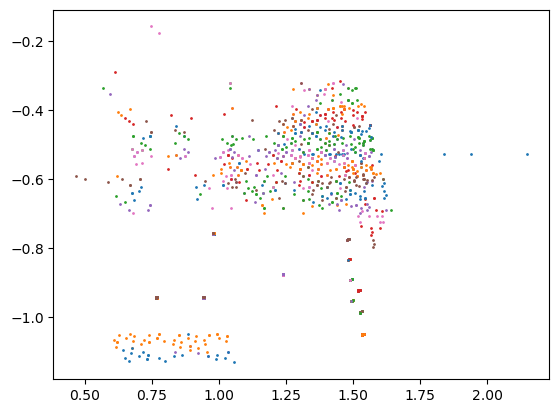

In [14]:
colors = [f'C{i}' for i in range(7)]
for i, (bin_id, g) in enumerate(train_dataset._df.groupby('bin')):
    plt.scatter(g.ra, g.dec, label=bin_id, color=colors[i%len(colors)], s=1)

# Train

In [49]:
batch_size = 1024
num_workers = 4
pin_memory = True if device == 'cuda' else False
trainloader, valloader = train_dataset.get_dataloader(batch_size, num_workers = num_workers, pin_memory = pin_memory, random_seed=20)
dataset_size = np.prod(len(train_dataset))
batches_per_dataset = dataset_size // batch_size
lr_scheduler = 'cosine_annealing'
lr_scheduler_kwargs = {'T_max': batches_per_dataset, 'eta_min': 1e-6}


In [50]:
len(trainloader)

9765625

In [52]:
len(trainloader.dataset)

14930

In [51]:
len(trainloader.dataset) // batch_size

14

In [30]:
lr_scheduler_step_freq = 100
num_epochs=5
batch_size=512
iterations_per_epoch = len(train_dataset) // batch_size
total_steps = int(num_epochs * iterations_per_epoch)
num_lr_scheduler_steps = total_steps // lr_scheduler_step_freq

In [32]:
len(train_dataset), batch_size, iterations_per_epoch, total_steps

(1149, 512, 2, 10)

In [34]:
50 * 900 / 64

703.125

In [14]:
"""Algorithm and Train setup"""
exp_name_prefix = 'v1f-environment-testing2'

bc_alg_config = {
    'obs_dim': dataset.obs_dim,
    'num_actions': dataset.num_actions,
    'hidden_dim': 1024,
    'device': device,
    'lr': 3e-3,
    'loss_fxn': torch.nn.CrossEntropyLoss(),
    'lr_scheduler': 'cosine_annealing',
    'lr_scheduler_kwargs': lr_scheduler_kwargs
}
alg = BehaviorCloning(**bc_alg_config)

# ddqn_alg_config = {
#     'obs_dim': dataset.obs_dim,
#     'num_actions': dataset.num_actions,
#     'hidden_dim': 128,
#     'device': device,
#     'gamma': .95,
#     'tau': 1e-4,
#     'lr': 1e-3,
#     'loss_fxn': None,
#     use_double=True,
# }
# alg = DDQN(**ddqn_alg_config)

fit_config = {
    'num_epochs': 5, #ie, number of iterations through entire dataset
    'batch_size': batch_size,
    # 'learning_start': 
    }

env_name = 'OfflineEnv'

def create_exp_name(alg, env_name, dataset, fit_config, alg_config, prefix=None):
    if prefix is not None:
        exp_name = prefix
    else:
        exp_name = ''
    exp_name += f"{alg.name}"
    exp_name += f"-{env_name}"
    exp_name += f"-n_nights={dataset.n_nights}"
    # config_prefix += f"-use_double={alg_config['use_double']}"
    exp_name += f"-num_epochs={fit_config['num_epochs']}"
    exp_name += f"-batch_size={fit_config['batch_size']}"
    exp_name += f"-lr={alg_config['lr']}"
    return exp_name

exp_name = create_exp_name(alg, env_name, dataset, fit_config, bc_alg_config, prefix=exp_name_prefix)

outdir = f'../results/{exp_name}/'
if not os.path.exists(outdir):
    os.makedirs(outdir)
fig_outdir = outdir + 'figures/'
if not os.path.exists(fig_outdir):
    os.makedirs(fig_outdir)

agent_config = {
    'algorithm': alg,
    'train_outdir': outdir
    }

agent = Agent(**agent_config)

# Train

In [15]:
# circle on gif is a 1.1deg radius --> maybe nside = 16 is enough, (nside=32 is about a 3 deg area)

In [16]:
import time

In [17]:
do_train = True
load_previous = False
    
if os.path.exists(outdir + 'best_weights.pt') and load_previous:
    print('Loading best_weights.pt')
    agent.load(filepath=outdir + 'best_weights.pt')
if do_train:
    start_time = time.time()
    """Train"""
    agent.fit(
        dataloader=trainloader,
        **fit_config
        )
    end_time = time.time()
    train_time = end_time - start_time
    print(f'Total train time = {train_time}s on {device}')

  0%|                                         | 2/11315 [00:00<36:26,  5.17it/s]

Validation check at train step 0: val_loss = 6.255 logit = -0.474 accuracy = 0.044


  1%|▎                                      | 102/11315 [00:08<17:59, 10.39it/s]

Validation check at train step 100: val_loss = 2.573 logit = -8.626 accuracy = 0.283


  2%|▋                                      | 202/11315 [00:17<15:37, 11.85it/s]

Validation check at train step 200: val_loss = 2.046 logit = -10.995 accuracy = 0.369


  3%|█                                      | 302/11315 [00:25<21:59,  8.34it/s]

Validation check at train step 300: val_loss = 1.766 logit = -11.203 accuracy = 0.431


  4%|█▍                                     | 402/11315 [00:33<15:22, 11.84it/s]

Validation check at train step 400: val_loss = 1.649 logit = -11.742 accuracy = 0.453


  4%|█▋                                     | 502/11315 [00:41<15:04, 11.95it/s]

Validation check at train step 500: val_loss = 1.524 logit = -12.685 accuracy = 0.489


  5%|██                                     | 602/11315 [00:49<14:29, 12.32it/s]

Validation check at train step 600: val_loss = 1.404 logit = -12.893 accuracy = 0.500


  6%|██▍                                    | 702/11315 [00:57<14:39, 12.07it/s]

Validation check at train step 700: val_loss = 1.437 logit = -13.311 accuracy = 0.464


  7%|██▊                                    | 802/11315 [01:06<15:00, 11.67it/s]

Validation check at train step 800: val_loss = 1.284 logit = -12.885 accuracy = 0.520


  8%|███                                    | 902/11315 [01:14<19:29,  8.90it/s]

Validation check at train step 900: val_loss = 1.158 logit = -13.786 accuracy = 0.577


  9%|███▎                                  | 1002/11315 [01:22<14:51, 11.57it/s]

Validation check at train step 1000: val_loss = 1.260 logit = -14.670 accuracy = 0.513


 10%|███▋                                  | 1102/11315 [01:30<14:53, 11.43it/s]

Validation check at train step 1100: val_loss = 1.036 logit = -14.489 accuracy = 0.605


 11%|████                                  | 1202/11315 [01:39<14:26, 11.67it/s]

Validation check at train step 1200: val_loss = 1.020 logit = -14.956 accuracy = 0.598


 12%|████▎                                 | 1302/11315 [01:47<14:51, 11.23it/s]

Validation check at train step 1300: val_loss = 0.982 logit = -15.079 accuracy = 0.600


 12%|████▋                                 | 1402/11315 [01:55<14:18, 11.54it/s]

Validation check at train step 1400: val_loss = 0.933 logit = -14.696 accuracy = 0.638


 13%|█████                                 | 1502/11315 [02:04<19:49,  8.25it/s]

Validation check at train step 1500: val_loss = 0.880 logit = -15.335 accuracy = 0.672


 14%|█████▍                                | 1602/11315 [02:11<13:25, 12.06it/s]

Validation check at train step 1600: val_loss = 0.810 logit = -15.538 accuracy = 0.659


 15%|█████▋                                | 1702/11315 [02:19<13:55, 11.51it/s]

Validation check at train step 1700: val_loss = 0.818 logit = -15.664 accuracy = 0.684


 16%|██████                                | 1802/11315 [02:27<12:30, 12.68it/s]

Validation check at train step 1800: val_loss = 0.831 logit = -16.171 accuracy = 0.678


 17%|██████▍                               | 1902/11315 [02:35<13:04, 12.00it/s]

Validation check at train step 1900: val_loss = 0.740 logit = -16.744 accuracy = 0.709


 18%|██████▋                               | 2002/11315 [02:43<13:13, 11.74it/s]

Validation check at train step 2000: val_loss = 0.662 logit = -16.904 accuracy = 0.750


 19%|███████                               | 2102/11315 [02:51<16:31,  9.29it/s]

Validation check at train step 2100: val_loss = 0.821 logit = -16.610 accuracy = 0.680


 19%|███████▍                              | 2202/11315 [02:58<12:46, 11.89it/s]

Validation check at train step 2200: val_loss = 0.676 logit = -16.856 accuracy = 0.722


 20%|███████▋                              | 2302/11315 [03:07<13:03, 11.51it/s]

Validation check at train step 2300: val_loss = 0.638 logit = -17.238 accuracy = 0.747


 21%|████████                              | 2402/11315 [03:15<13:22, 11.11it/s]

Validation check at train step 2400: val_loss = 0.616 logit = -17.613 accuracy = 0.758


 22%|████████▍                             | 2502/11315 [03:23<12:11, 12.05it/s]

Validation check at train step 2500: val_loss = 0.772 logit = -17.017 accuracy = 0.692


 23%|████████▋                             | 2602/11315 [03:31<12:08, 11.97it/s]

Validation check at train step 2600: val_loss = 0.662 logit = -17.632 accuracy = 0.718


 24%|█████████                             | 2702/11315 [03:39<15:21,  9.35it/s]

Validation check at train step 2700: val_loss = 0.618 logit = -18.208 accuracy = 0.751


 25%|█████████▍                            | 2802/11315 [03:47<12:02, 11.78it/s]

Validation check at train step 2800: val_loss = 0.648 logit = -17.249 accuracy = 0.729


 26%|█████████▋                            | 2902/11315 [03:56<12:04, 11.61it/s]

Validation check at train step 2900: val_loss = 0.612 logit = -17.833 accuracy = 0.759


 27%|██████████                            | 3002/11315 [04:04<12:11, 11.36it/s]

Validation check at train step 3000: val_loss = 0.507 logit = -18.477 accuracy = 0.798


 27%|██████████▍                           | 3102/11315 [04:12<11:19, 12.10it/s]

Validation check at train step 3100: val_loss = 0.571 logit = -18.847 accuracy = 0.752


 28%|██████████▊                           | 3202/11315 [04:20<12:21, 10.94it/s]

Validation check at train step 3200: val_loss = 0.523 logit = -18.460 accuracy = 0.791


 29%|███████████                           | 3302/11315 [04:28<14:06,  9.47it/s]

Validation check at train step 3300: val_loss = 0.605 logit = -18.248 accuracy = 0.762


 30%|███████████▍                          | 3402/11315 [04:36<11:19, 11.65it/s]

Validation check at train step 3400: val_loss = 0.681 logit = -17.618 accuracy = 0.720


 31%|███████████▊                          | 3502/11315 [04:44<11:20, 11.47it/s]

Validation check at train step 3500: val_loss = 0.481 logit = -19.073 accuracy = 0.803


 32%|████████████                          | 3602/11315 [04:53<10:30, 12.23it/s]

Validation check at train step 3600: val_loss = 0.626 logit = -19.090 accuracy = 0.728


 33%|████████████▍                         | 3702/11315 [05:01<10:37, 11.94it/s]

Validation check at train step 3700: val_loss = 0.566 logit = -19.065 accuracy = 0.760


 34%|████████████▊                         | 3802/11315 [05:09<11:00, 11.38it/s]

Validation check at train step 3800: val_loss = 0.434 logit = -19.098 accuracy = 0.822


 34%|█████████████                         | 3902/11315 [05:17<13:09,  9.39it/s]

Validation check at train step 3900: val_loss = 0.506 logit = -18.959 accuracy = 0.793


 35%|█████████████▍                        | 4002/11315 [05:25<10:17, 11.84it/s]

Validation check at train step 4000: val_loss = 0.481 logit = -19.338 accuracy = 0.803


 36%|█████████████▊                        | 4102/11315 [05:33<10:04, 11.94it/s]

Validation check at train step 4100: val_loss = 0.553 logit = -19.758 accuracy = 0.752


 37%|██████████████                        | 4202/11315 [05:41<10:06, 11.72it/s]

Validation check at train step 4200: val_loss = 0.351 logit = -20.098 accuracy = 0.862


 38%|██████████████▍                       | 4302/11315 [05:49<09:38, 12.12it/s]

Validation check at train step 4300: val_loss = 0.534 logit = -18.943 accuracy = 0.765


 39%|██████████████▊                       | 4402/11315 [05:57<10:09, 11.34it/s]

Validation check at train step 4400: val_loss = 0.332 logit = -19.973 accuracy = 0.866


 40%|███████████████                       | 4502/11315 [06:06<11:49,  9.61it/s]

Validation check at train step 4500: val_loss = 0.397 logit = -18.936 accuracy = 0.842


 41%|███████████████▍                      | 4602/11315 [06:13<09:09, 12.21it/s]

Validation check at train step 4600: val_loss = 0.516 logit = -18.426 accuracy = 0.805


 42%|███████████████▊                      | 4702/11315 [06:22<09:08, 12.05it/s]

Validation check at train step 4700: val_loss = 0.336 logit = -19.847 accuracy = 0.862


 42%|████████████████▏                     | 4802/11315 [06:30<09:08, 11.88it/s]

Validation check at train step 4800: val_loss = 0.382 logit = -19.850 accuracy = 0.832


 43%|████████████████▍                     | 4902/11315 [06:38<09:04, 11.77it/s]

Validation check at train step 4900: val_loss = 0.362 logit = -20.037 accuracy = 0.857


 44%|████████████████▊                     | 5002/11315 [06:46<08:50, 11.90it/s]

Validation check at train step 5000: val_loss = 0.348 logit = -19.197 accuracy = 0.858


 45%|█████████████████▏                    | 5102/11315 [06:54<11:35,  8.93it/s]

Validation check at train step 5100: val_loss = 0.298 logit = -20.078 accuracy = 0.879


 46%|█████████████████▍                    | 5202/11315 [07:02<08:25, 12.09it/s]

Validation check at train step 5200: val_loss = 0.353 logit = -20.277 accuracy = 0.858


 47%|█████████████████▊                    | 5302/11315 [07:11<08:43, 11.49it/s]

Validation check at train step 5300: val_loss = 0.340 logit = -20.502 accuracy = 0.847


 48%|██████████████████▏                   | 5402/11315 [07:19<08:20, 11.81it/s]

Validation check at train step 5400: val_loss = 0.320 logit = -19.663 accuracy = 0.860


 49%|██████████████████▍                   | 5502/11315 [07:27<07:52, 12.30it/s]

Validation check at train step 5500: val_loss = 0.461 logit = -19.880 accuracy = 0.791


 50%|██████████████████▊                   | 5602/11315 [07:35<08:17, 11.48it/s]

Validation check at train step 5600: val_loss = 0.265 logit = -20.260 accuracy = 0.890


 50%|███████████████████▏                  | 5702/11315 [07:43<09:46,  9.56it/s]

Validation check at train step 5700: val_loss = 0.354 logit = -20.503 accuracy = 0.865


 51%|███████████████████▍                  | 5802/11315 [07:51<07:38, 12.03it/s]

Validation check at train step 5800: val_loss = 0.292 logit = -20.102 accuracy = 0.888


 52%|███████████████████▊                  | 5902/11315 [07:59<07:22, 12.23it/s]

Validation check at train step 5900: val_loss = 0.278 logit = -20.684 accuracy = 0.894


 53%|████████████████████▏                 | 6002/11315 [08:07<07:19, 12.08it/s]

Validation check at train step 6000: val_loss = 0.471 logit = -20.233 accuracy = 0.803


 54%|████████████████████▍                 | 6102/11315 [08:15<07:09, 12.13it/s]

Validation check at train step 6100: val_loss = 0.301 logit = -19.287 accuracy = 0.885


 55%|████████████████████▊                 | 6202/11315 [08:23<07:40, 11.11it/s]

Validation check at train step 6200: val_loss = 0.249 logit = -20.371 accuracy = 0.898


 56%|█████████████████████▏                | 6302/11315 [08:31<08:59,  9.29it/s]

Validation check at train step 6300: val_loss = 0.562 logit = -20.709 accuracy = 0.756


 57%|█████████████████████▌                | 6402/11315 [08:39<07:11, 11.38it/s]

Validation check at train step 6400: val_loss = 0.240 logit = -20.353 accuracy = 0.908


 57%|█████████████████████▊                | 6502/11315 [08:48<07:06, 11.28it/s]

Validation check at train step 6500: val_loss = 0.238 logit = -21.234 accuracy = 0.906


 58%|██████████████████████▏               | 6602/11315 [08:56<06:33, 11.99it/s]

Validation check at train step 6600: val_loss = 0.256 logit = -20.790 accuracy = 0.896


 59%|██████████████████████▌               | 6702/11315 [09:04<06:21, 12.10it/s]

Validation check at train step 6700: val_loss = 0.569 logit = -20.323 accuracy = 0.752


 60%|██████████████████████▊               | 6802/11315 [09:12<06:29, 11.59it/s]

Validation check at train step 6800: val_loss = 0.270 logit = -20.318 accuracy = 0.888


 61%|███████████████████████▏              | 6902/11315 [09:20<08:09,  9.01it/s]

Validation check at train step 6900: val_loss = 0.227 logit = -21.216 accuracy = 0.917


 62%|███████████████████████▌              | 7002/11315 [09:28<06:05, 11.81it/s]

Validation check at train step 7000: val_loss = 0.372 logit = -20.197 accuracy = 0.842


 63%|███████████████████████▊              | 7102/11315 [09:36<05:54, 11.89it/s]

Validation check at train step 7100: val_loss = 0.240 logit = -20.893 accuracy = 0.902


 64%|████████████████████████▏             | 7202/11315 [09:44<05:54, 11.62it/s]

Validation check at train step 7200: val_loss = 0.215 logit = -21.450 accuracy = 0.922


 65%|████████████████████████▌             | 7302/11315 [09:52<05:27, 12.26it/s]

Validation check at train step 7300: val_loss = 0.298 logit = -21.417 accuracy = 0.871


 65%|████████████████████████▊             | 7402/11315 [10:01<05:30, 11.83it/s]

Validation check at train step 7400: val_loss = 0.394 logit = -21.100 accuracy = 0.839


 66%|█████████████████████████▏            | 7502/11315 [10:09<06:47,  9.35it/s]

Validation check at train step 7500: val_loss = 0.250 logit = -20.121 accuracy = 0.896


 67%|█████████████████████████▌            | 7602/11315 [10:17<05:02, 12.29it/s]

Validation check at train step 7600: val_loss = 0.217 logit = -21.510 accuracy = 0.912


 68%|█████████████████████████▊            | 7702/11315 [10:25<05:16, 11.42it/s]

Validation check at train step 7700: val_loss = 0.279 logit = -21.561 accuracy = 0.891


 69%|██████████████████████████▏           | 7802/11315 [10:33<04:55, 11.89it/s]

Validation check at train step 7800: val_loss = 0.240 logit = -21.824 accuracy = 0.887


 70%|██████████████████████████▌           | 7902/11315 [10:42<04:46, 11.91it/s]

Validation check at train step 7900: val_loss = 0.238 logit = -22.193 accuracy = 0.907


 71%|██████████████████████████▊           | 8002/11315 [10:50<04:33, 12.13it/s]

Validation check at train step 8000: val_loss = 0.390 logit = -18.941 accuracy = 0.842


 72%|███████████████████████████▏          | 8102/11315 [10:58<06:03,  8.85it/s]

Validation check at train step 8100: val_loss = 0.209 logit = -20.738 accuracy = 0.915


 72%|███████████████████████████▌          | 8202/11315 [11:06<04:16, 12.16it/s]

Validation check at train step 8200: val_loss = 0.213 logit = -21.103 accuracy = 0.903


 73%|███████████████████████████▉          | 8302/11315 [11:14<04:11, 12.00it/s]

Validation check at train step 8300: val_loss = 0.241 logit = -21.732 accuracy = 0.900


 74%|████████████████████████████▏         | 8402/11315 [11:22<04:13, 11.47it/s]

Validation check at train step 8400: val_loss = 0.208 logit = -21.635 accuracy = 0.918


 75%|████████████████████████████▌         | 8502/11315 [11:30<04:04, 11.52it/s]

Validation check at train step 8500: val_loss = 0.195 logit = -21.864 accuracy = 0.925


 76%|████████████████████████████▉         | 8602/11315 [11:38<03:44, 12.07it/s]

Validation check at train step 8600: val_loss = 0.417 logit = -19.745 accuracy = 0.850


 77%|█████████████████████████████▏        | 8702/11315 [11:46<04:45,  9.16it/s]

Validation check at train step 8700: val_loss = 0.191 logit = -21.069 accuracy = 0.929


 78%|█████████████████████████████▌        | 8802/11315 [11:54<03:25, 12.25it/s]

Validation check at train step 8800: val_loss = 0.213 logit = -21.580 accuracy = 0.890


 79%|█████████████████████████████▉        | 8902/11315 [12:02<03:21, 11.96it/s]

Validation check at train step 8900: val_loss = 0.194 logit = -21.617 accuracy = 0.911


 80%|██████████████████████████████▏       | 9002/11315 [12:11<03:08, 12.28it/s]

Validation check at train step 9000: val_loss = 0.214 logit = -21.176 accuracy = 0.902


 80%|██████████████████████████████▌       | 9102/11315 [12:19<03:12, 11.47it/s]

Validation check at train step 9100: val_loss = 0.178 logit = -21.915 accuracy = 0.927


 81%|██████████████████████████████▉       | 9202/11315 [12:27<02:54, 12.12it/s]

Validation check at train step 9200: val_loss = 0.246 logit = -22.015 accuracy = 0.880


 82%|███████████████████████████████▏      | 9302/11315 [12:35<03:41,  9.10it/s]

Validation check at train step 9300: val_loss = 0.260 logit = -22.157 accuracy = 0.893


 83%|███████████████████████████████▌      | 9402/11315 [12:43<02:42, 11.77it/s]

Validation check at train step 9400: val_loss = 0.181 logit = -21.961 accuracy = 0.930


 84%|███████████████████████████████▉      | 9502/11315 [12:52<02:27, 12.29it/s]

Validation check at train step 9500: val_loss = 0.210 logit = -22.334 accuracy = 0.907


 85%|████████████████████████████████▏     | 9602/11315 [13:00<02:23, 11.91it/s]

Validation check at train step 9600: val_loss = 0.297 logit = -22.365 accuracy = 0.881


 86%|████████████████████████████████▌     | 9702/11315 [13:08<02:13, 12.10it/s]

Validation check at train step 9700: val_loss = 0.209 logit = -20.329 accuracy = 0.910


 87%|████████████████████████████████▉     | 9802/11315 [13:16<02:05, 12.03it/s]

Validation check at train step 9800: val_loss = 0.180 logit = -21.648 accuracy = 0.917


 88%|█████████████████████████████████▎    | 9902/11315 [13:24<02:40,  8.80it/s]

Validation check at train step 9900: val_loss = 0.173 logit = -22.115 accuracy = 0.930


 88%|████████████████████████████████▋    | 10002/11315 [13:32<01:48, 12.13it/s]

Validation check at train step 10000: val_loss = 0.254 logit = -22.526 accuracy = 0.882


 89%|█████████████████████████████████    | 10102/11315 [13:40<01:40, 12.09it/s]

Validation check at train step 10100: val_loss = 0.175 logit = -22.372 accuracy = 0.931


 90%|█████████████████████████████████▎   | 10202/11315 [13:48<01:31, 12.23it/s]

Validation check at train step 10200: val_loss = 0.195 logit = -22.928 accuracy = 0.917


 91%|█████████████████████████████████▋   | 10302/11315 [13:56<01:23, 12.08it/s]

Validation check at train step 10300: val_loss = 0.267 logit = -22.658 accuracy = 0.881


 92%|██████████████████████████████████   | 10402/11315 [14:05<01:15, 12.02it/s]

Validation check at train step 10400: val_loss = 0.216 logit = -20.855 accuracy = 0.914


 93%|██████████████████████████████████▎  | 10502/11315 [14:13<01:26,  9.37it/s]

Validation check at train step 10500: val_loss = 0.175 logit = -21.969 accuracy = 0.944


 94%|██████████████████████████████████▋  | 10602/11315 [14:21<00:59, 11.89it/s]

Validation check at train step 10600: val_loss = 0.297 logit = -21.529 accuracy = 0.872


 95%|██████████████████████████████████▉  | 10702/11315 [14:29<00:53, 11.52it/s]

Validation check at train step 10700: val_loss = 0.147 logit = -22.209 accuracy = 0.944


 95%|███████████████████████████████████▎ | 10802/11315 [14:37<00:42, 12.08it/s]

Validation check at train step 10800: val_loss = 0.185 logit = -22.705 accuracy = 0.922


 96%|███████████████████████████████████▋ | 10902/11315 [14:45<00:33, 12.23it/s]

Validation check at train step 10900: val_loss = 0.208 logit = -22.680 accuracy = 0.917


 97%|███████████████████████████████████▉ | 11002/11315 [14:53<00:26, 11.97it/s]

Validation check at train step 11000: val_loss = 0.234 logit = -22.721 accuracy = 0.897


 98%|████████████████████████████████████▎| 11102/11315 [15:01<00:23,  9.12it/s]

Validation check at train step 11100: val_loss = 0.158 logit = -22.920 accuracy = 0.938


 99%|████████████████████████████████████▋| 11202/11315 [15:09<00:09, 12.34it/s]

Validation check at train step 11200: val_loss = 0.263 logit = -22.920 accuracy = 0.888


100%|████████████████████████████████████▉| 11302/11315 [15:17<00:01, 11.99it/s]

Validation check at train step 11300: val_loss = 0.240 logit = -21.036 accuracy = 0.901


100%|█████████████████████████████████████| 11315/11315 [15:18<00:00, 12.31it/s]

Total train time = 918.9943506717682s on cpu


In [18]:
with open(outdir + 'train_metrics.pkl', 'rb') as handle:
    train_metrics = pickle.load(handle)
with open(outdir + 'val_metrics.pkl', 'rb') as handle:
    val_metrics = pickle.load(handle)

In [77]:
train_metrics['lr']

[0.0015004999999999999,
 0.0015004999999999997,
 0.0015005000000000034,
 0.0015004999999999997,
 0.0015005000000000177,
 0.0015004999999999997,
 0.001500500000000011,
 0.0015004999999999997,
 0.0015005000000000144,
 0.0015004999999999997,
 0.0015004999999999966,
 0.0015004999999999997,
 0.0015005000000000218,
 0.0015004999999999997,
 0.001500500000000047,
 0.0015004999999999997,
 0.001500500000000029,
 0.0015004999999999997,
 0.0015005000000000112,
 0.0015004999999999997,
 0.0015004999999999936,
 0.0015004999999999997,
 0.001500499999999976,
 0.0015004999999999997,
 0.0015005000000000437,
 0.0015004999999999997,
 0.0015005000000001116,
 0.0015004999999999997,
 0.0015005000000000936,
 0.0015004999999999997,
 0.0015005000000000762,
 0.0015004999999999997,
 0.0015005000000000586,
 0.0015004999999999997,
 0.0015005000000002113,
 0.0015004999999999997,
 0.0015005000000001937,
 0.0015004999999999997,
 0.0015005000000001762,
 0.0015004999999999997,
 0.0015005000000001586,
 0.00150049999999999

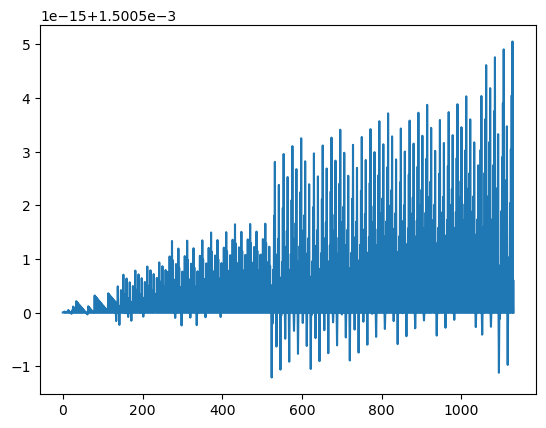

In [75]:
plt.plot(train_metrics['lr'])

In [110]:
val_steps = np.arange(start=0,
          stop=len(train_metrics['train_loss']),
                   step=len(train_metrics['train_loss']) / len(val_metrics['val_loss'])
         )

In [116]:
val_steps = np.linspace(0, len(train_metrics['train_loss']), len(val_metrics['accuracy']))

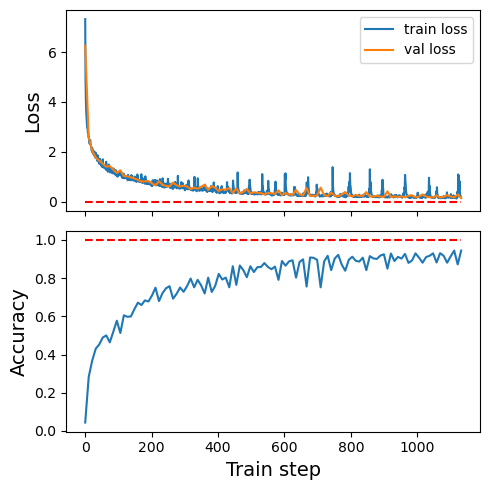

In [117]:
fig, axs = plt.subplots(2, sharex=True, figsize=(5, 5))


axs[0].plot(train_metrics['train_loss'], label='train loss')
axs[0].plot(val_steps, val_metrics['val_loss'], label='val loss')
axs[0].hlines(y=0, xmin=0, xmax=len(train_metrics['train_loss']), color='red', linestyle='--')
axs[0].set_ylabel('Loss', fontsize=14)
axs[0].legend()

axs[1].plot(np.linspace(0, len(train_metrics['train_loss']), len(val_metrics['accuracy'])), val_metrics['accuracy'])
axs[1].hlines(y=1, xmin=0, xmax=len(train_metrics['train_loss']), color='red', linestyle='--')
axs[1].set_xlabel('Train step', fontsize=14)
axs[1].set_ylabel('Accuracy', fontsize=14)
axs[1].set_xlabel('Train step', fontsize=14)
fig.tight_layout()
fig.savefig(fig_outdir + 'train_history.png')

# Roll out policy on train dataset

## Using gym.env

In [26]:
specific_days

In [29]:
random.choices(np.arange(31), k=3)

[np.int64(14), np.int64(15), np.int64(8)]

In [34]:
test_dataset = OfflineDECamDataset(
    df, 
    binning_method=binning_method,
    nside=nside,
    bin_space=bin_space,
    specific_years=specific_years,
    specific_months=specific_months,
    specific_days=random.choices(specific_days, k=3) if specific_days is not None else random.choices(np.arange(31), k=3), #np.arange(30, step=5),
    include_default_features=include_default_features,
    include_bin_features=include_bin_features,
    do_z_score_norm=do_z_score_norm,
    do_cyclical_norm=do_cyclical_norm,
)

Calculating sun and moon ra/dec and az/el: 100%|█| 394/394 [00:00<00:00, 509.89i
Calculating zenith states: 100%|█████████████████| 3/3 [00:00<00:00, 475.85it/s]


In [35]:
test_dataset.n_nights

3

In [36]:
from survey_ops.src.environments import OfflineEnv

In [37]:
gym.register(
    id=f"gymnasium_env/{env_name}",
    entry_point=OfflineEnv,
    #max_episode_steps=1000000,  # Prevent infinite episodes. Here just set to 300 even though episode will terminate when stepping to last element of sequence
)

# for eval step only
env_config = {
    'id': f"gymnasium_env/{env_name}",
    'test_dataset': test_dataset,
    'max_nights': None,
}

env = gym.make(**env_config)

/home/rachel/miniconda3/envs/cosmoML/lib/python3.11/site-packages/gymnasium/envs/registration.py:636: UserWarning: WARN: Overriding environment gymnasium_env/OfflineEnv already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")


In [38]:
import random

In [31]:
obs, info = env.reset()

In [24]:
test_dataset._df.bin[1]

np.int32(134)

In [30]:
bin_num = test_dataset._df.bin[1]
time = test_dataset._df.timestamp[1]
fields_in_bin = env.unwrapped.get_fields_in_bin(bin_num=bin_num, timestamp=time)
field = random.choice(fields_in_bin)
bin_num, field

(np.int32(134), np.int32(3357))

In [26]:
next_state, reward, terminated, truncated, info = env.step(action=(bin_num, field))


NameError: name 'bin_num' is not defined

In [42]:
action

np.int64(99)

In [43]:
test_dataset.bin2coord[action]

(np.float64(3.478191866474414), np.float64(1.2116520114493072))

In [44]:
from survey_ops.src.eval_utils import get_fields_in_azel_bin

In [60]:
field_bins, incomplete_fields_mask = get_fields_in_azel_bin(bin_num=action, timestamp=timestamp, field2nvisits=field2nvisits, field_ids=field_ids, field_radecs=field_radecs, hpGrid=env.unwrapped.hpGrid, visited=env.unwrapped._visited)

Mask:  [False False False ... False False False]
43 16266
(array([248]),) (array([    0,     1,     2, ..., 16263, 16264, 16265], shape=(16266,)),)


In [61]:
field_bins

array([None, None, None, ..., 453, 167, 250], shape=(16266,), dtype=object)

In [63]:
np.count_nonzero(incomplete_fields_mask)

np.int64(16266)

In [64]:
np.where(field_bins==action)

(array([ 1780,  1781,  2127,  2272,  2273,  2284,  2392,  2395,  2449,
         2461,  2531,  2582,  2594,  2608,  2611,  2615,  3524,  6315,
         8650,  8678,  8679,  8680,  9511, 10145, 10621, 10738, 10811,
        10813, 10814, 11355, 12519, 13165, 13166, 13199, 13725, 14160,
        14161, 14162, 14457, 15670, 15671, 15691, 15892]),)

In [72]:
np.count_nonzero(field_bins == action & incomplete_fields_mask==True)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [ ]:
# valid fields are fields in bin and fields which have not been completed
print('Mask: ', field_bins == bin_num & incomplete_fields_mask)
print(np.count_nonzero(field_bins == bin_num), np.count_nonzero(incomplete_fields_mask))
print(np.where(field_ids==bin_num), np.where(incomplete_fields_mask == True))
fields_in_bin = field_ids[field_bins == bin_num & incomplete_fields_mask]

In [52]:
test_dataset._get_fields_in_azel_bin(action, timestamp)

array([], dtype=int32)

In [53]:
from survey_ops.utils import ephemerides

In [54]:
action

np.int64(139)

In [55]:
fields_az, fields_el = ephemerides.equatorial_to_topographic(ra=dataset.field_radecs[:, 0], dec=dataset.field_radecs[:, 1], time=timestamp)
field_bins = dataset.hpGrid.ang2idx(lon=fields_az, lat=fields_el)

In [57]:
field_bins

array([840, 775, 775, ..., 389, 193, 155], shape=(16266,), dtype=object)

In [56]:
np.where(field_bins == action)

(array([], dtype=int64),)

In [129]:
np.count_nonzero(field_bins == action)

np.int64(1)

In [130]:
random.choice(test_dataset.field_ids[field_bins == action])

np.int32(3964)

In [131]:
fields_el[2964]

np.float64(1.2192938327789307)

In [117]:
action

np.int64(9)

In [122]:
test_dataset.field_ids

array([    0,     1,     2, ..., 16263, 16264, 16265],
      shape=(16266,), dtype=int32)

In [118]:
np.unique(field_bins[field_bins != None])

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 12, 17, 18, 19, 23, 24, 31, 32, 33,
       34, 35, 40, 49, 50, 51, 52, 53, 54, 55, 60, 71, 72, 73, 74, 75, 76,
       77, 78, 79, 84, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107,
       127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 161,
       162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 199,
       200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212,
       241, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254,
       287, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301,
       338, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352,
       392, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406,
       407, 453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464,
       465, 466, 505, 506, 516, 517, 518, 519, 520, 521, 522, 523, 524,
       525, 526, 527, 528, 529, 555, 570, 581, 582, 583, 584, 585, 586,
       587, 588, 589, 590, 591, 592, 593, 594, 618, 619, 

In [ ]:
field

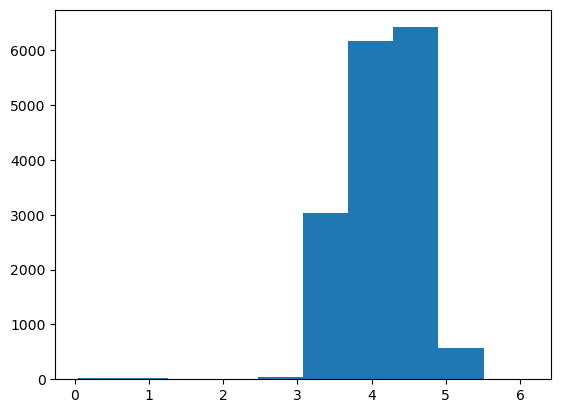

(array([ 205.,  205.,  787., 2126., 3485., 2948., 2479., 2220., 1642.,
         169.]),
 array([-0.8416065 , -0.60140033, -0.36119416, -0.12098799,  0.11921818,
         0.35942435,  0.59963052,  0.83983669,  1.08004286,  1.32024903,
         1.5604552 ]),
 <BarContainer object of 10 artists>)

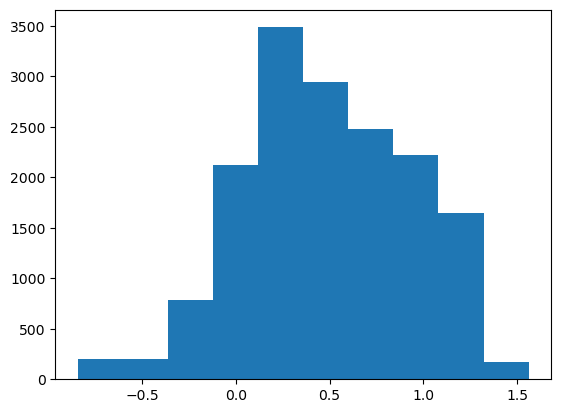

In [119]:
plt.hist(fields_az)
plt.show();
plt.hist(fields_el)

In [23]:
# evaluation metrics
agent.algorithm.policy_net.eval()
episode_rewards = []
eval_metrics = {}
hpGrid = env.unwrapped.test_dataset.hpGrid
get_fields_in_bin = env.unwrapped.get_fields_in_bin
field2nvisits, field2radec, field_ids, field_radecs = env.unwrapped.field2nvisits, env.unwrapped.field2radec, env.unwrapped.field_ids, env.unwrapped.field_radecs


obs, info = env.reset()
episode_reward = 0
terminated = False
truncated = False
num_nights = env.unwrapped.max_nights
observations = {f'night-{i}': [] for i in range(num_nights)}
rewards = {f'night-{i}': [] for i in range(num_nights)}
timestamps = {f'night-{i}': [] for i in range(num_nights)}
fields = {f'night-{i}': [] for i in range(num_nights)}
bins = {f'night-{i}': [] for i in range(num_nights)}

i = 0
reward = 0
night_idx = 0
while not (terminated or truncated):
    with torch.no_grad():
        timestamp = info.get('timestamp')
        observations[f'night-{night_idx}'].append(obs)
        rewards[f'night-{night_idx}'].append(reward)
        timestamps[f'night-{night_idx}'].append(info.get('timestamp'))
        fields[f'night-{night_idx}'].append(info.get('field_id'))
        bins[f'night-{night_idx}'].append(info.get('bin'))

        action_mask = info.get('action_mask', None)
        action = agent.act(obs, action_mask, epsilon=None)
        fields_in_bin = get_fields_in_bin(bin_num=action, timestamp=timestamp, field2nvisits=field2nvisits, field_ids=field_ids, field_radecs=field_radecs, hpGrid=hpGrid, visited=info.get('visited'))
        field_id = agent.choose_field(obs=obs, info=info, field2nvisits=field2nvisits, field2radec=field2radec, hpGrid=hpGrid, field_choice_method='random', fields_in_bin=fields_in_bin)

        actions = np.array([action, field_id], dtype=np.int32)
        obs, reward, terminated, truncated, info = env.step(actions)
        episode_reward += reward
        night_idx = info.get('night_idx')
        i += 1
for night_idx in range(num_nights):
    observations[f'night-{night_idx}'] = np.array(observations[f'night-{night_idx}'])
    rewards[f'night-{night_idx}'] = np.array(rewards[f'night-{night_idx}'])
    timestamps[f'night-{night_idx}'] = np.array(timestamps[f'night-{night_idx}'])
    fields[f'night-{night_idx}'] = np.array(fields[f'night-{night_idx}'])
    bins[f'night-{night_idx}'] = np.array(bins[f'night-{night_idx}'])
eval_metrics.update({f'ep-0': {
    'observations': observations,
    'rewards': rewards,
    'timestamp': timestamps,
    'field_id': fields,
    'bin': bins
}})

episode_rewards.append(episode_reward)
print(f'terminated at {i}')

eval_metrics.update({
    'mean_reward': np.mean(episode_rewards),
    'std_reward': np.std(episode_rewards),
    'min_reward': np.min(episode_rewards),
    'max_reward': np.max(episode_rewards),
    'episode_rewards': episode_rewards,
})

NameError: name 'bin_nums' is not defined

In [71]:
eval_metrics['ep-0']['timestamp'].keys()

dict_keys(['night-0', 'night-1'])

In [72]:
eval_metrics['ep-0']['timestamp']['night-1']

array([1514688437, 1514688557, 1514688677, 1514688797, 1514688917,
       1514689037, 1514689157, 1514689277, 1514689397, 1514689517,
       1514689637, 1514689757, 1514689877, 1514689997, 1514690117,
       1514690237, 1514690357, 1514690477, 1514690597, 1514690717,
       1514690837, 1514690957, 1514691077, 1514691197, 1514691317,
       1514691437, 1514691557, 1514691677, 1514691797, 1514691917,
       1514692037, 1514692157, 1514692277, 1514692397, 1514692517,
       1514692637, 1514692757, 1514692877, 1514692997, 1514693117,
       1514693237, 1514693357, 1514693477, 1514693597, 1514693717,
       1514693837, 1514693957, 1514694077, 1514694197, 1514694317,
       1514694437, 1514694557, 1514694677, 1514694797, 1514694917,
       1514695037])

In [33]:
agent.evaluate(env=env, num_episodes=1, field_choice_method='random', eval_outdir=outdir)
with open(outdir + 'eval_metrics.pkl', 'rb') as handle:
    eval_metrics_agent = pickle.load(handle)

  0%|                                                     | 0/1 [00:00<?, ?it/s]


KeyError: 'night-0'

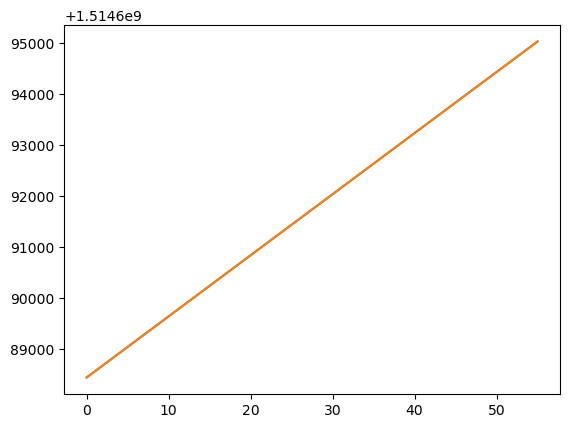

In [76]:
plt.plot(eval_metrics['ep-0']['timestamp']['night-1'])
plt.plot(eval_metrics_agent['ep-0']['timestamp']['night-1'])
# plt.plot(test_dataset._df['timestamp'].values)

## Evaluate agent given environment

In [39]:
agent.evaluate(env=env, num_episodes=1, field_choice_method='random', eval_outdir=outdir)
with open(outdir + 'eval_metrics.pkl', 'rb') as handle:
    eval_metrics = pickle.load(handle)

100%|████████████████████████████████████████████| 1/1 [03:40<00:00, 220.77s/it]

terminated at step 495
eval_metrics.pkl saved in ../results/v1f-environment-testing2BehaviorCloning-OfflineEnv-n_nights=19-num_epochs=5-batch_size=1024-lr=0.003/


In [40]:
ep_num = 0

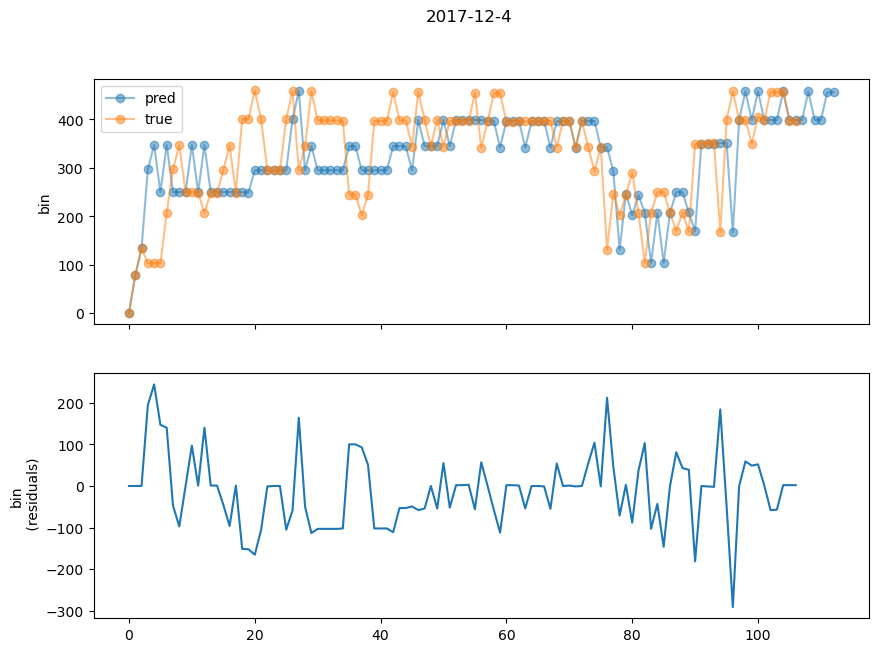

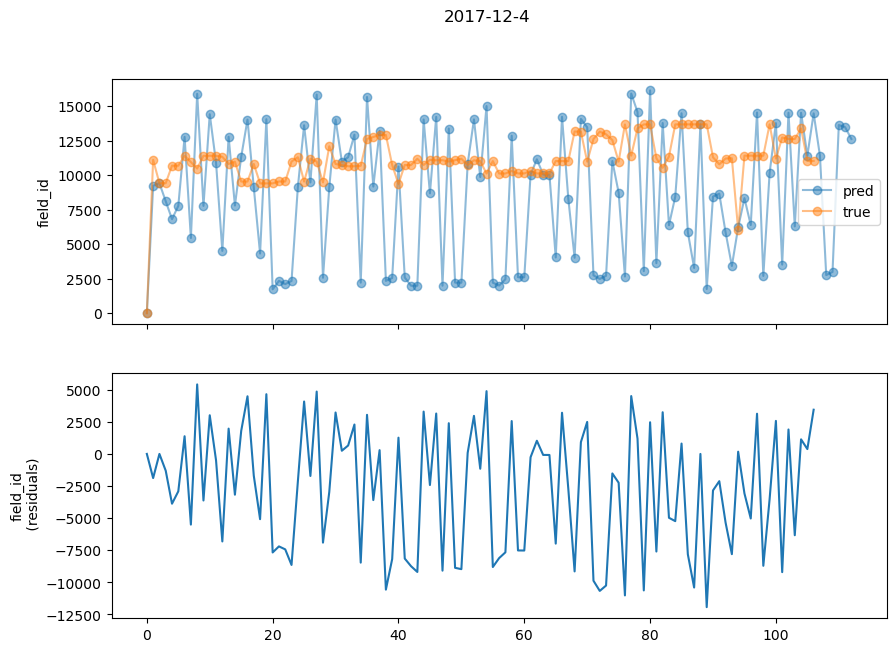

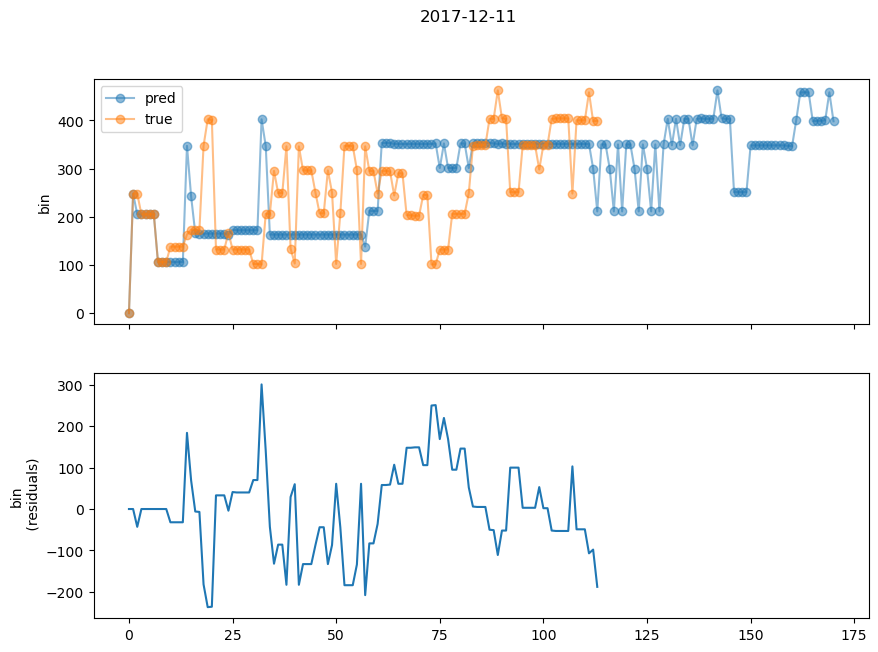

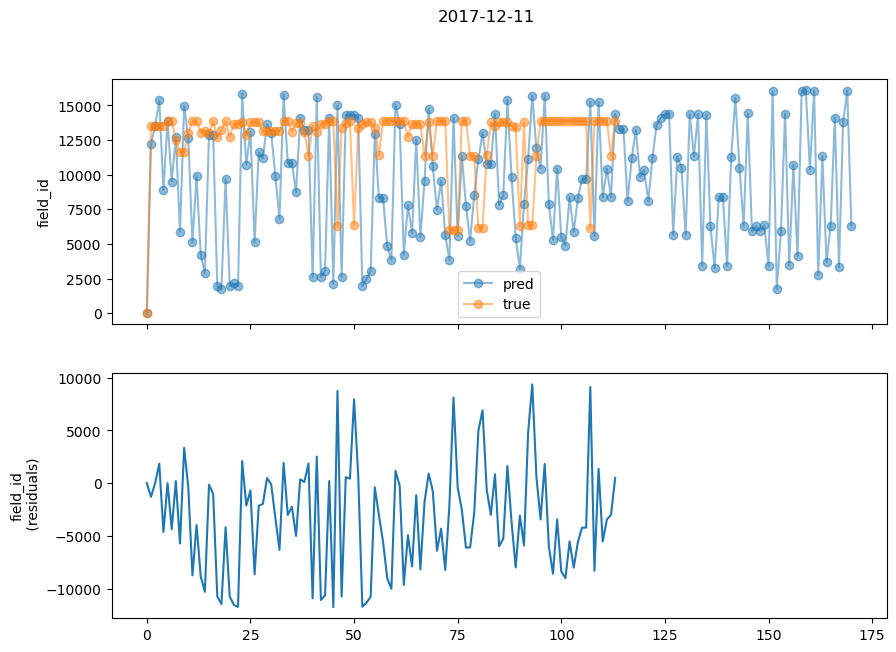

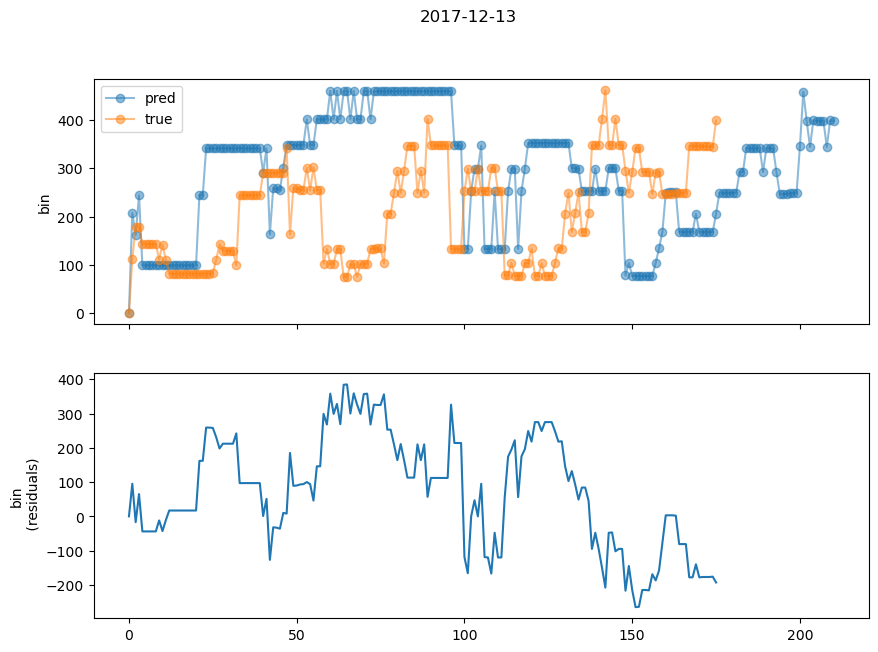

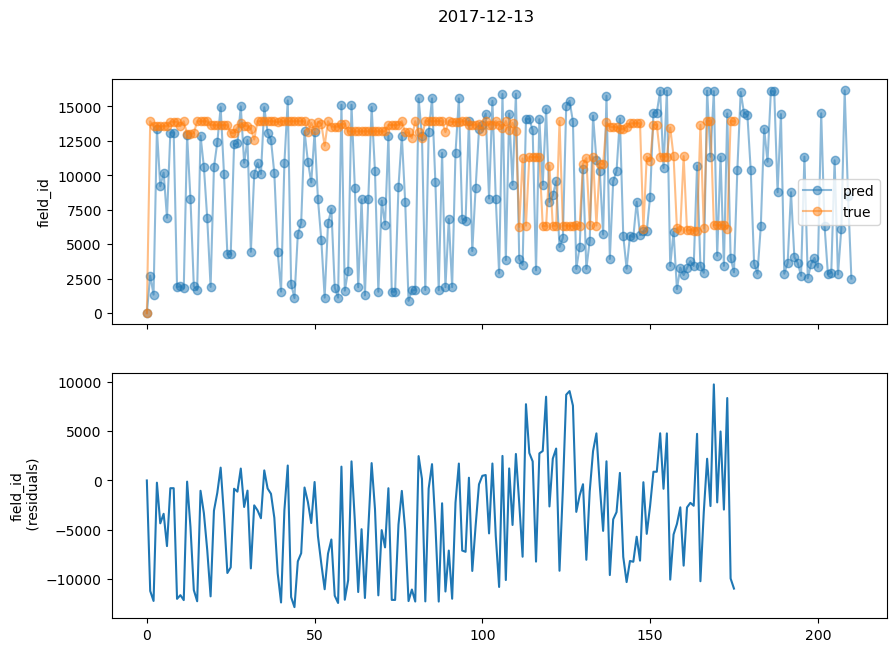

In [41]:
for night_idx, (night_name, night_group) in enumerate(test_dataset._df.groupby('night')):
    date = night_name.date()
    date_str = f"{date.year}-{date.month}-{date.day}"
    
    # Plot bins vs step
    fig_b, axs_b = plt.subplots(2, figsize=(10,7), sharex=True)
    axs_b[0].plot(eval_metrics[f'ep-{ep_num}']['bin'][f'night-{night_idx}'], marker='o', label='pred', alpha=.5)
    axs_b[0].plot(night_group['bin'].values.astype(int), marker='o', label='true', alpha=.5)
    axs_b[0].legend()
    axs_b[0].set_ylabel('bin')
    axs_b[1].plot(eval_metrics[f'ep-{ep_num}']['bin'][f'night-{night_idx}'][:len(night_group['bin'].values.astype(int))] \
                - night_group['bin'].values.astype(int)[:len(eval_metrics[f'ep-{ep_num}']['bin'][f'night-{night_idx}'])])
    axs_b[1].set_ylabel('bin' + '\n (residuals)')
    fig_b.suptitle(date_str)
    fig_b.savefig(fig_outdir + date_str + f'bin_vs_step.png')
    # plt.close()
    
    # Plot fields vs step
    fig_f, axs_f = plt.subplots(2, figsize=(10,7), sharex=True)
    axs_f[0].plot(eval_metrics[f'ep-{ep_num}']['field_id'][f'night-{night_idx}'], marker='o', label='pred', alpha=.5)
    axs_f[0].plot(night_group['field_id'].values.astype(int), marker='o', label='true', alpha=.5)
    axs_f[0].legend()
    axs_f[0].set_ylabel('field_id')
    axs_f[1].plot(eval_metrics[f'ep-{ep_num}']['field_id'][f'night-{night_idx}'][:len(night_group['field_id'].values.astype(int))] \
                - night_group['field_id'].values.astype(int)[:len(eval_metrics[f'ep-{ep_num}']['field_id'][f'night-{night_idx}'])])
    axs_f[1].set_ylabel('field_id' + '\n (residuals)')
        
    fig_f.suptitle(date_str)
    fig_f.savefig(fig_outdir + date_str + f'field_id_vs_step.png')
    # plt.close()


In [42]:
eval_metrics['ep-0']['observations'][f'night-0'].shape

(113, 22)

In [43]:
night_idx=10

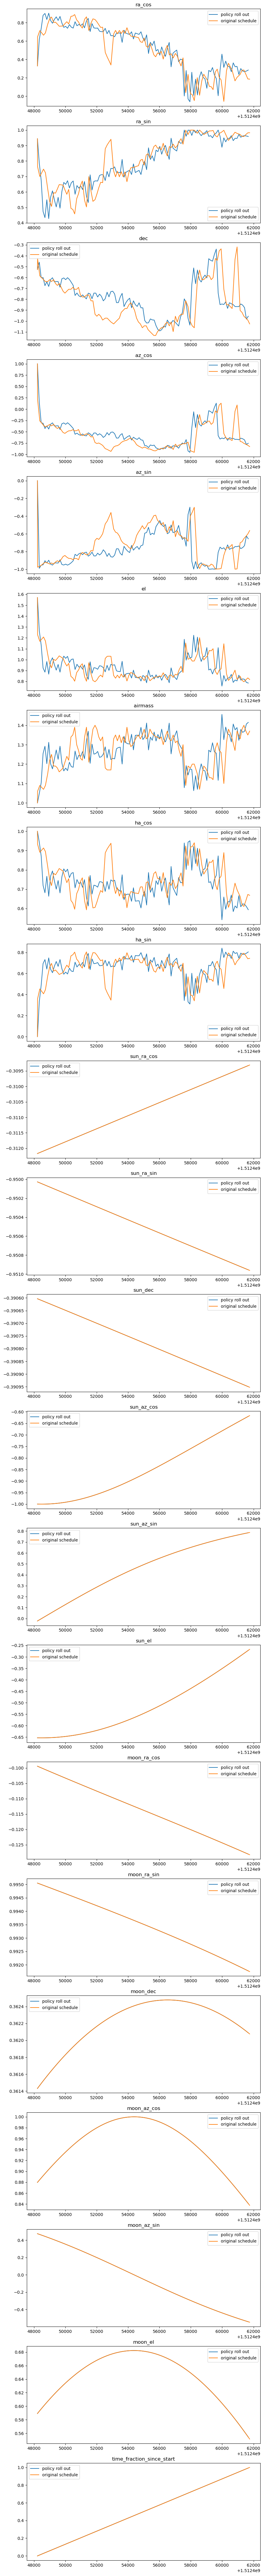

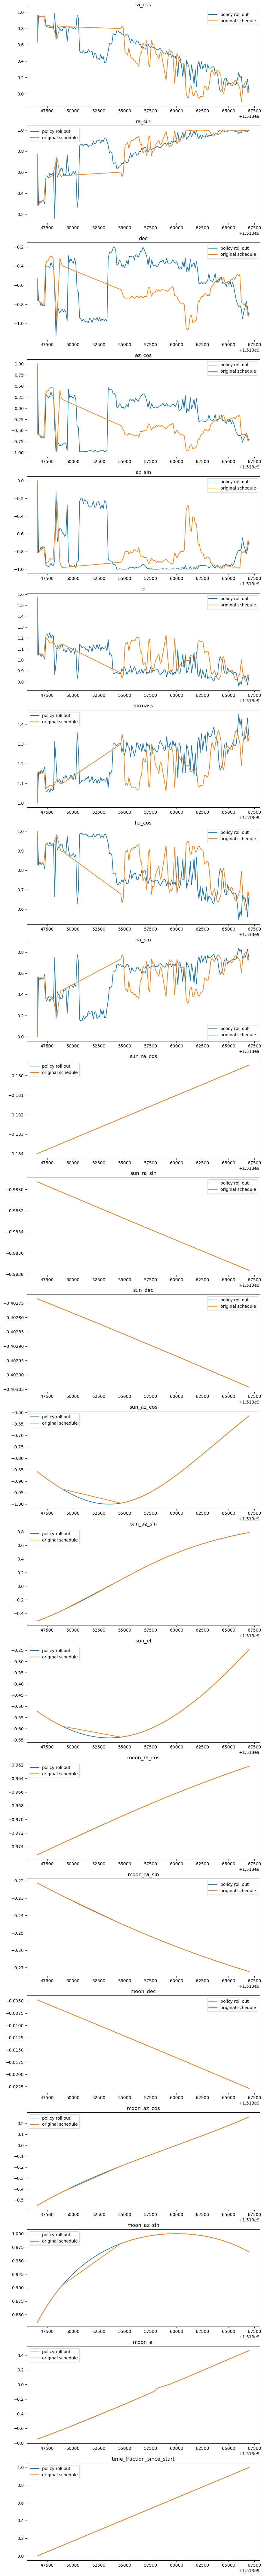

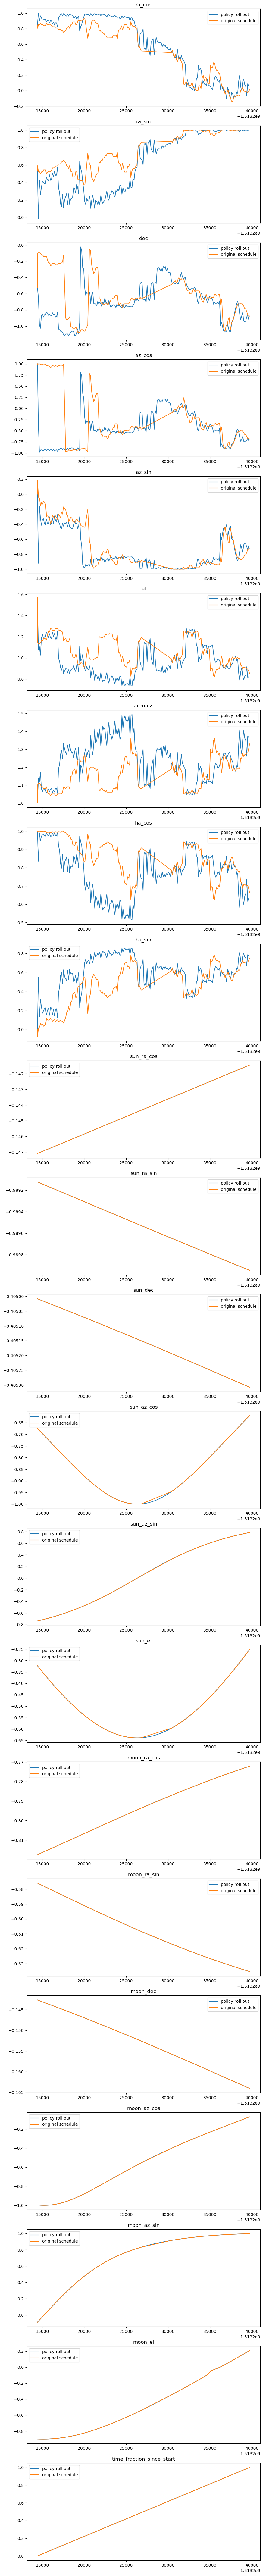

In [175]:
for night_idx, (night_name, night_group) in enumerate(test_dataset._df.groupby('night')):
    date = night_name.date()
    date_str = f"{date.year}-{date.month}-{date.day}"
    
    fig, axs = plt.subplots(len(dataset.state_feature_names), figsize=(10, len(dataset.state_feature_names)*5))
    for i, feature_row in enumerate(eval_metrics['ep-0']['observations'][f'night-{night_idx}'].T):
        feat_name = env.unwrapped.test_dataset.state_feature_names[i]
        eval_timestamps = eval_metrics['ep-0']['timestamp'][f'night-{night_idx}']
        if feat_name == 'airmass':
            eval_data = 1 / feature_row
        elif 'dec' in feat_name or 'el' in feat_name:
            eval_data = feature_row * (np.pi/2)
        else:
            eval_data = feature_row
        axs[i].plot(eval_timestamps, eval_data, label='policy roll out')
        axs[i].plot(night_group['timestamp'], night_group[feat_name].values, label='original schedule')
        axs[i].set_title(feat_name)
        axs[i].legend()


In [47]:
with open('../experiment_results/test_experiment/offline_dataset_config.pkl', 'rb') as f:
    OFFLINE_CONFIG = pickle.load(f)

In [71]:
dataset._df.night.unique()

<DatetimeArray>
['2017-12-04 00:00:00', '2017-12-05 00:00:00', '2017-12-06 00:00:00',
 '2017-12-07 00:00:00', '2017-12-08 00:00:00', '2017-12-09 00:00:00',
 '2017-12-10 00:00:00', '2017-12-11 00:00:00', '2017-12-12 00:00:00',
 '2017-12-13 00:00:00', '2017-12-14 00:00:00', '2017-12-20 00:00:00',
 '2017-12-21 00:00:00', '2017-12-22 00:00:00', '2017-12-23 00:00:00',
 '2017-12-24 00:00:00', '2017-12-25 00:00:00', '2017-12-29 00:00:00',
 '2017-12-30 00:00:00']
Length: 19, dtype: datetime64[ns]

In [70]:
test_dataset._df.night.unique()

<DatetimeArray>
['2017-12-04 00:00:00', '2017-12-11 00:00:00', '2017-12-13 00:00:00']
Length: 3, dtype: datetime64[ns]

In [52]:
('../data/')

{'binning_method': 'healpix',
 'nside': 16,
 'bin_space': 'radec',
 'include_default_features': True,
 'no_bin_features': True,
 'no_cyclical_norm': True,
 'no_max_norm': True,
 'no_inverse_airmass': True}

In [50]:
test_dataset.hpGrid.nside

16

In [42]:
for name, group in dataset._df.groupby('night'):
    print(len(group))

107
103
198
213
209
151
211
114
150
176
191
2
65
101
100
69
62
9
51


In [44]:
orig_field_radecs

array([[ 0.82816824, -0.98337303]])

In [45]:
eval_metrics['ep-0']['field_id'][f'night-{night_idx}'].astype(int)

array([-1])

In [47]:
from survey_ops.utils import ephemerides

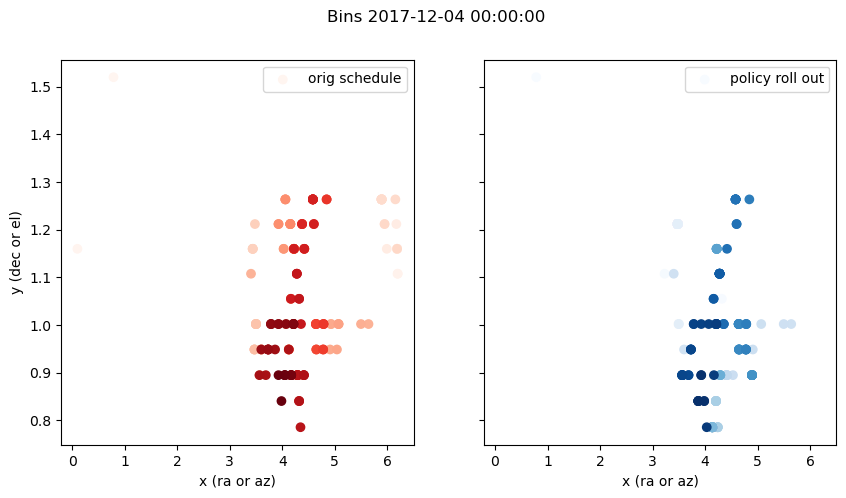

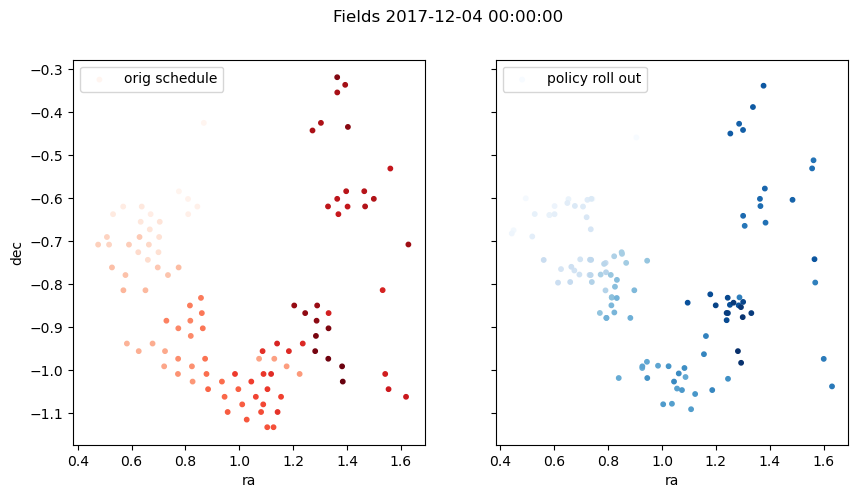

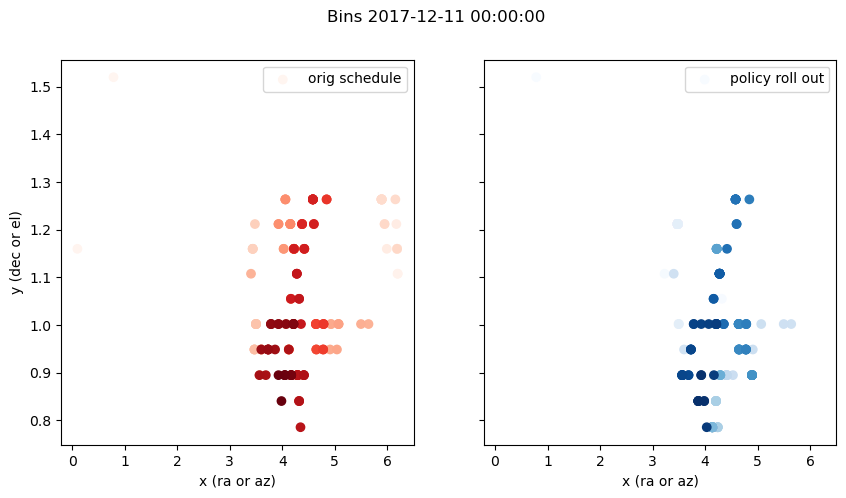

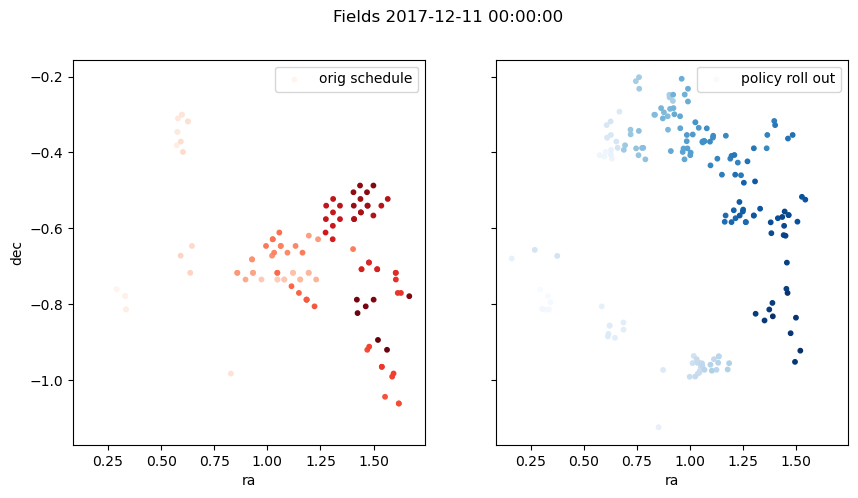

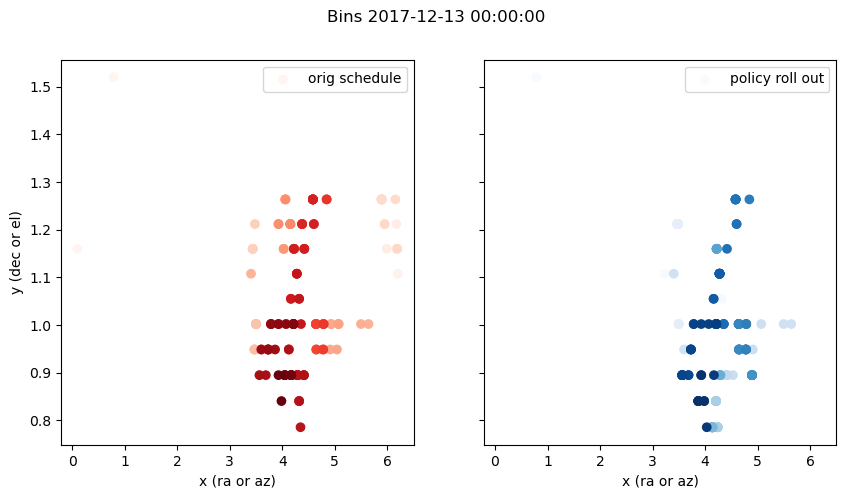

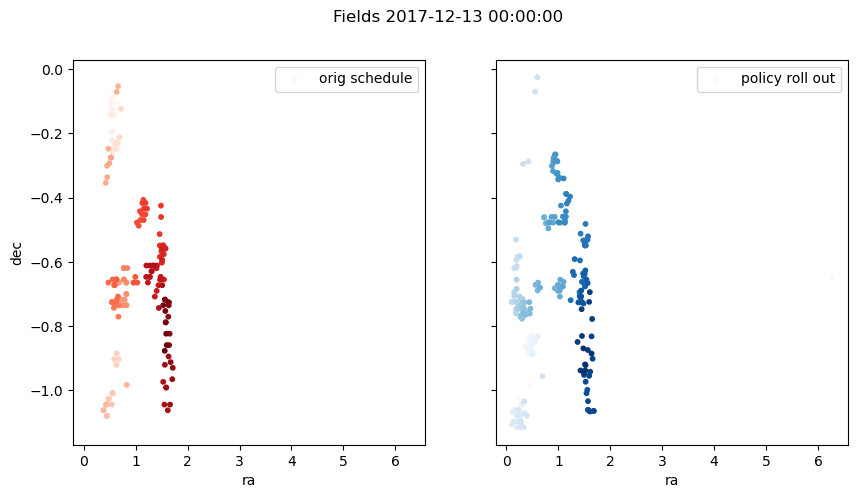

In [48]:
for night_idx, (night_name, night_group) in enumerate(test_dataset._df.groupby('night')):
    # Get radecs of bins and fields for this night
    eval_bin_coords = np.array([env.unwrapped.test_dataset.bin2coord[bin_num] for bin_num in eval_metrics['ep-0']['bin'][f'night-{night_idx}'].astype(int) if bin_num != -1])
    orig_bin_coords = np.array([env.unwrapped.test_dataset.bin2coord[bin_num] for bin_num in night_group['bin'].values if bin_num != -1])

    eval_field_radecs = np.array([env.unwrapped.test_dataset.field2radec[field_id] for field_id in eval_metrics['ep-0']['field_id'][f'night-{night_idx}'].astype(int) if field_id != -1])
    orig_field_radecs = np.array([env.unwrapped.test_dataset.field2radec[field_id] for field_id in night_group['field_id'].values.astype(int) if field_id != -1])
    
    
    if len(orig_field_radecs) != 1:
        # Plot each night
        fig, axs = plt.subplots(1, 2, figsize=(10,5), sharex=True, sharey=True)
        axs[0].scatter(orig_bin_radecs[:, 0], orig_bin_radecs[:, 1], label='orig schedule', cmap='Reds', c=np.arange(len(orig_bin_radecs)))
        axs[1].scatter(eval_bin_radecs[:, 0], eval_bin_radecs[:, 1], label='policy roll out', cmap='Blues', c=np.arange(len(eval_bin_radecs)))
        for ax in axs:
            ax.set_xlabel('x (ra or az)')
            ax.legend()
        axs[0].set_ylabel('y (dec or el)')
        fig.suptitle(f'Bins {night_name}')
        
        fig, axs = plt.subplots(1, 2, figsize=(10,5), sharex=True, sharey=True)
        axs[0].scatter(orig_field_radecs[:, 0], orig_field_radecs[:, 1], label='orig schedule', cmap='Reds', c=np.arange(len(orig_field_radecs)), s=10)
        axs[1].scatter(eval_field_radecs[:, 0], eval_field_radecs[:, 1], label='policy roll out', cmap='Blues', c=np.arange(len(eval_field_radecs)), s=10)
        for ax in axs:
            ax.set_xlabel('ra')
            ax.legend()
        axs[0].set_ylabel('dec')
        fig.suptitle(f'Fields {night_name}')

In [66]:
eval_metrics['ep-0'].keys()

dict_keys(['observations', 'rewards', 'timestamp', 'field_id', 'bin'])

In [67]:
save_schedules = True
if save_schedules:
    _timestamps = eval_metrics['ep-0']['timestamp'] \
                  if len(eval_metrics['ep-0']['timestamp']) > len(env.unwrapped.test_dataset._df['timestamp']) \
                  else env.unwrapped.test_dataset._df['timestamp'] 
    eval_field_schedule = {
        'time': _timestamps,
        'field_id': eval_metrics['field_id']['ep-0']
    }
    
    orig_field_schedule = {
        'time': _timestamps,
        'field_id': env.unwrapped.test_dataset._df['field_id'].values
    }
    
    # bin_schedule = {
    #     'time': train_dataset_subset._df['timestamp'].values[:len(eval_metrics['timestamps']['ep-0'])],
    #     'policy_bin_id': eval_metrics['bin']['ep-0'][:len(train_dataset_subset._df['bin'].values)],
    #     'bin_id': train_dataset_subset._df['bin'].values[:len(eval_metrics['timestamps']['ep-0'])]
    # }

    
    bin_schedule = {
        'time': _timestamps,
        'policy_bin_id': eval_metrics['bin']['ep-0'].astype(np.int32),
        'bin_id': env.unwrapped.test_dataset._df['bin'].values
    }
    
    schedule_outdir = '../results/v2f-environment-testing/'
    if not os.path.exists(schedule_outdir):
        os.makedirs(schedule_outdir)
    for data, filename in zip(
        [orig_field_schedule, eval_field_schedule, bin_schedule],
        ['ood_original_schedule.csv', 'ood_eval_schedule.csv', 'ood_bin_schedule.csv']
        ):
        series_data = {key: pd.Series(value) for key, value in data.items()}
        _df = pd.DataFrame(series_data)
        if 'bin' in filename:
            _df['policy_bin_id'] = _df['policy_bin_id'].fillna(0).astype('Int64')
            _df['bin_id'] = _df['bin_id'].fillna(0).astype('Int64')
            print(_df.tail(15))
        output_filepath = '../results/v2f-environment-testing/' + filename
        with open(output_filepath, 'w') as f:
            _df.to_csv(f, index=False)

KeyError: 'field_id'

In [89]:
# schedule file: columns `time` and `field_id`
# bin_schedule file: "time", "policy_bin_id", and "bin_id"

## Instead of trajectory, send agent batch of all states to get best next action

In [90]:
specific_years, specific_months, specific_days

([2014, 2015, 2016], [12], None)

In [179]:
test_dataset = OfflineDECamDataset(
    df, 
    binning_method=binning_method,
    nside=nside,
    bin_space=bin_space,
    specific_years=[2014],
    specific_months=[12],
    specific_days=None,
    include_default_features=include_default_features,
    include_bin_features=include_bin_features,
    do_z_score_norm=do_z_score_norm,
    do_cyclical_norm=do_cyclical_norm,
)

Calculating zenith states: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 356.41it/s]


In [181]:
np.where(test_dataset.states[:, -1] == 0)

(array([   1,  289,  316,  539,  757,  972, 1087, 1317, 1546, 1712, 1895,
        1944, 2163, 2354, 2574, 2786, 2988, 3097, 3099, 3208, 3318]),)

In [192]:
with torch.no_grad():
    q_vals = agent.algorithm.policy_net(test_dataset.states.to(device))
    eval_actions = torch.argmax(q_vals, dim=1).to('cpu').detach().numpy()
    

In [193]:
# get index of the first observation for each night
first_obs_in_night_indices = []
for key, indices in test_dataset._df.groupby('night').indices.items():
    first_obs_in_night_indices.append(indices[0])

In [194]:
# Sequence of actions from target (original schedule) and policy
target_sequence = test_dataset.actions.detach().numpy()
eval_sequence = eval_actions

# # Given the action (bin) chosen in the original schedule and in the policy's schedule
# # obtain the angular separation between the two bins for all actions
# target_radec = np.array([dataset.binid2radec[bin_id] for bin_id in target_sequence])
# eval_radec = np.array([dataset.binid2radec[bin_id] for bin_id in eval_sequence])
# # target_angsep = np.array([angular_separation(pos1=target_radec[i]*units.deg, pos2=target_radec[i+1]*units.deg) for i in range(len(target_radec) - 1)]) / units.deg
# # eval_angsep = np.array([angular_separation(pos1=eval_radec[i]*units.deg, pos2=eval_radec[i+1]*units.deg) for i in range(len(target_radec) - 1)]) / units.deg
# target_eval_angsep = np.array([angular_separation(eval_radec[i]*units.deg, pos2=target_radec[i]*units.deg) for i in range(len(target_radec))]) / units.deg

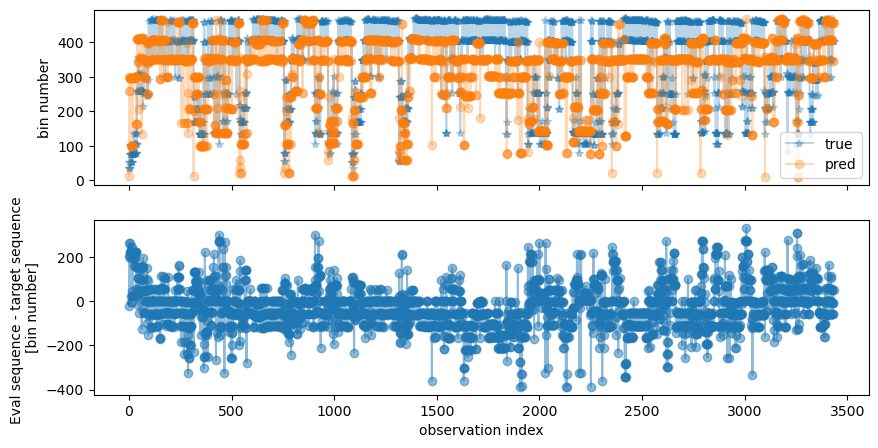

In [195]:
fig, axs = plt.subplots(2, figsize=(10,5), sharex=True)
axs[0].plot(target_sequence, marker='*', alpha=.3, label='true')
axs[0].plot(eval_sequence, marker='o', alpha=.3, label='pred')
axs[0].legend()
axs[0].set_ylabel('bin number')
axs[1].plot(eval_sequence - target_sequence, marker='o', alpha=.5)
axs[1].set_ylabel('Eval sequence - target sequence \n[bin number]')
axs[1].set_xlabel('observation index')
fig.savefig(fig_outdir + 'train_eval_and_target_bin_sequences.png')

In [190]:
eval_sequence

array([457, 464, 464, ..., 139, 139, 139], shape=(3434,))

In [148]:
target_sequence

array([2274, 2274, 2274, 2338, 2338, 2466, 2466, 2466, 2467, 2466, 2467,
       2402, 2467, 2467, 2467, 2467, 2593, 2853, 2853, 2854, 2810, 2894,
       2894, 2930, 2894, 2894, 2894, 2894, 2894, 2854, 2855, 2855, 2811,
       2810, 2710, 2654, 2655, 2710, 2711, 2655, 2655, 2763, 2339, 2339,
       2339, 2339, 2339, 2275, 2274, 2274, 2211, 2211, 2147, 2147, 2147,
       2084, 2019, 2019, 2020, 2020, 2084, 2084, 2084, 2148, 2212, 2148,
       2212, 2148, 2212, 2212, 2276, 2340, 2340, 2404, 2276, 2213, 2213,
       2149, 2149, 2085, 2149, 2086, 1958, 1958, 1894, 1894, 1831, 2277,
       2277, 2405, 2405, 2343, 2344, 2343, 2278, 2150, 2150, 2087, 2087,
       2023, 2088, 1960, 1833, 2025, 2024, 2152, 2152, 2152, 2216, 2279,
       2279, 2280, 2280, 2344, 2344, 2280, 2216], dtype=int32)

In [149]:
test_eval_bin_radecs = np.array([test_dataset.bin2radec[bin_id] for bin_id in eval_sequence])
test_target_bin_radecs = np.array([test_dataset.bin2radec[bin_id] for bin_id in target_sequence])

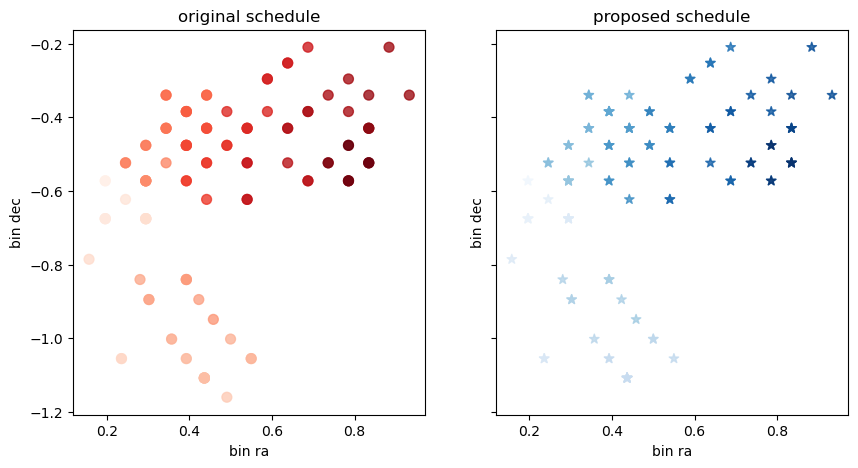

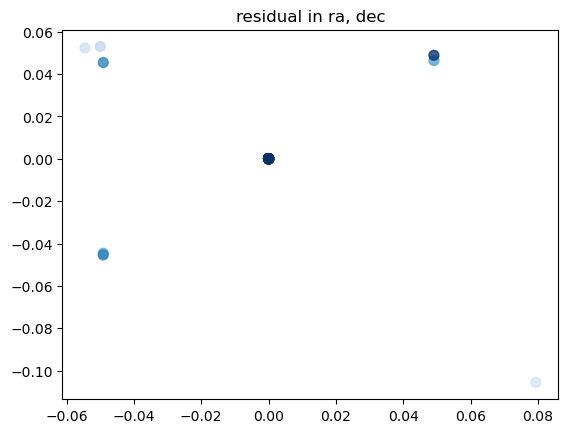

In [150]:
fig, axs = plt.subplots(1,2, figsize=(10, 5), sharex=True, sharey=True)
axs[0].scatter(test_target_bin_radecs[:, 0], test_target_bin_radecs[:, 1], cmap='Reds', s=50, alpha=.8, c=np.arange(len(test_target_bin_radecs)))
axs[1].scatter(test_eval_bin_radecs[:, 0], test_eval_bin_radecs[:, 1], cmap='Blues', alpha=.8, s=50, marker='*', c=np.arange(len(test_eval_bin_radecs)))
axs[0].set_title('original schedule')
axs[1].set_title('proposed schedule')
for ax in axs:
    ax.set_xlabel('bin ra')
    ax.set_ylabel('bin dec')
plt.show();

plt.scatter(test_eval_bin_radecs[:, 0] - test_target_bin_radecs[:, 0], test_eval_bin_radecs[:, 1] - test_target_bin_radecs[:, 1], cmap='Blues', s=50, c=np.arange(len(test_dataset)), alpha=.8)
plt.title('residual in ra, dec')
plt.show();


In [151]:
save_schedules = True
if save_schedules:
    eval_field_schedule = {
        'time': test_dataset._df['timestamp'].values[1:],
        'field_id': eval_sequence
    }
    orig_field_schedule = {
        'time': test_dataset._df['timestamp'].values[1:],
        'field_id': target_sequence
    }
    bin_schedule = {
        'time': test_dataset._df['timestamp'].values[1:],
        'policy_bin_id': eval_sequence,
        'bin_id': target_sequence
    }
    
    schedule_outdir = '../results/v2f-environment-testing/'
    if not os.path.exists(schedule_outdir):
        os.makedirs(schedule_outdir)
    for data, filename in zip(
        [orig_field_schedule, eval_field_schedule, bin_schedule],
        ['original_schedule.csv', 'eval_schedule.csv', 'bin_schedule.csv']
        ):
        _df = pd.DataFrame(data)
        output_filepath = '../results/v2f-environment-testing/' + filename
        with open(output_filepath, 'w') as f:
            _df.to_csv(f, index=False)

In [230]:
len(dataset.field2radec)

16266

# Using q-function interpolator

In [227]:
agent.algorithm.policy_net()

DQN(
  (layer1): Linear(in_features=22, out_features=1024, bias=True)
  (layer2): Linear(in_features=1024, out_features=1024, bias=True)
  (layer3): Linear(in_features=1024, out_features=3072, bias=True)
)

In [ ]:
interpolate_on_sphere(az, el, az_data=)